<a href="https://colab.research.google.com/drive/1LH4HinVwLGL-gYXot2zkoCIdxtMMI5N_" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[View Source Code](https://github.com/JunHL96/PyTorch-Course/blob/main/04_pytorch_custom_datasets_notes.ipynb) | [View Slides](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/slides/04_pytorch_custom_datasets.pdf) | [Watch Video Walkthrough](https://youtu.be/Z_ikDlimN6A?t=71010)

# 04. PyTorch Custom Datasets



In the last notebook, [notebook 03](https://www.learnpytorch.io/03_pytorch_computer_vision/), we looked at how to build computer vision models on an in-built dataset in PyTorch (FashionMNIST).

The steps we took are similar across many different problems in machine learning.

Find a dataset, turn the dataset into numbers, build a model (or find an existing model) to find patterns in those numbers that can be used for prediction.

PyTorch has many built-in datasets used for a wide number of machine learning benchmarks, however, you'll often want to use your own **custom dataset**.

## What is a custom dataset?



A **custom dataset** is a collection of data relating to a specific problem you're working on.

In essence, a **custom dataset** can be comprised of almost anything.

For example, if we were building a food image classification app like [Nutrify](https://nutrify.app), our custom dataset might be images of food.

Or if we were trying to build a model to classify whether or not a text-based review on a website was positive or negative, our custom dataset might be examples of existing customer reviews and their ratings.

Or if we were trying to build a sound classification app, our custom dataset might be sound samples alongside their sample labels.

Or if we were trying to build a recommendation system for customers purchasing things on our website, our custom dataset might be examples of products other people have bought.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-domain-libraries.png" alt="different pytorch domain libraries can be used for specific PyTorch problems" width=1000/>

*PyTorch includes many existing functions to load in various custom datasets in the [`TorchVision`](https://pytorch.org/vision/stable/index.html), [`TorchText`](https://pytorch.org/text/stable/index.html), [`TorchAudio`](https://pytorch.org/audio/stable/index.html) and [`TorchRec`](https://pytorch.org/torchrec/) domain libraries.*

But sometimes these existing functions may not be enough.

In that case, we can always subclass `torch.utils.data.Dataset` and customize it to our liking.

## What we're going to cover



We're going to be applying the PyTorch Workflow we covered in [notebook 01](https://www.learnpytorch.io/01_pytorch_workflow/) and [notebook 02](https://www.learnpytorch.io/02_pytorch_classification/) to a computer vision problem.

But instead of using an in-built PyTorch dataset, we're going to be using our own dataset of pizza, steak and sushi images.

The goal will be to load these images and then build a model to train and predict on them.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pytorch-food-vision-layout.png" alt="building a pipeline to load in food images and then building a pytorch model to classify those food images" width=800 />

*What we're going to build. We'll use `torchvision.datasets` as well as our own custom `Dataset` class to load in images of food and then we'll build a PyTorch computer vision model to hopefully be able to classify them.*

Specifically, we're going to cover:

| **Topic** | **Contents** |
| ----- | ----- |
| **0. Importing PyTorch and setting up device-agnostic code** | Let's get PyTorch loaded and then follow best practice to setup our code to be device-agnostic.  |
| **1. Get data** | We're going to be using our own **custom dataset** of pizza, steak and sushi images. |
| **2. Become one with the data (data preparation)** | At the beginning of any new machine learning problem, it's paramount to understand the data you're working with. Here we'll take some steps to figure out what data we have. |
| **3. Transforming data** |Often, the data you get won't be 100% ready to use with a machine learning model, here we'll look at some steps we can take to *transform* our images so they're ready to be used with a model. |
| **4. Loading data with `ImageFolder` (option 1)** | PyTorch has many in-built data loading functions for common types of data. `ImageFolder` is helpful if our images are in standard image classification format. |
| **5. Loading image data with a custom `Dataset`** | What if PyTorch didn't have an in-built function to load data with? This is where we can build our own custom subclass of `torch.utils.data.Dataset`. |
| **6. Other forms of transforms (data augmentation)** | Data augmentation is a common technique for expanding the diversity of your training data. Here we'll explore some of `torchvision`'s in-built data augmentation functions. |
| **7. Model 0: TinyVGG without data augmentation** | By this stage, we'll have our data ready, let's build a model capable of fitting it. We'll also create some training and testing functions for training and evaluating our model. |
| **8. Exploring loss curves** | Loss curves are a great way to see how your model is training/improving over time. They're also a good way to see if your model is **underfitting** or **overfitting**. |
| **9. Model 1: TinyVGG with data augmentation** | By now, we've tried a model *without*, how about we try one *with* data augmentation? |
| **10. Compare model results** | Let's compare our different models' loss curves and see which performed better and discuss some options for improving performance. |
| **11. Making a prediction on a custom image** | Our model is trained to on a dataset of pizza, steak and sushi images. In this section we'll cover how to use our trained model to predict on an image *outside* of our existing dataset. |

## 0. Importing PyTorch and setting up device-agnostic code

In [70]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.5.1+cu121'

And now let's follow best practice and setup device-agnostic code.

> **Note:** If you're using Google Colab, and you don't have a GPU turned on yet, it's now time to turn one on via `Runtime -> Change runtime type -> Hardware accelerator -> GPU`. If you do this, your runtime will likely reset and you'll have to run all of the cells above by going `Runtime -> Run before`.

In [71]:
# Device-Agnostic Code
if torch.cuda.is_available():
    device = "cuda" # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = "mps" # Apple GPU
else:
    device = "cpu" # Defaults to CPU if NVIDIA GPU/Apple GPU aren't available

print(f"Using device: {device}")

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}")

Using device: cuda
PyTorch version: 2.5.1+cu121


## 1. Acquire Data

To begin, we need a dataset. Fortunately, some data has already been prepared for us.

We'll start with a small subset because our goal isn't to train the largest model or use the biggest dataset initially. Machine learning is an iterative process: start small, achieve functionality, then scale up as needed.

We will use a subset of the [Food101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/). Food101 is a well-known computer vision benchmark containing 101,000 images of 101 different food categories (75,750 for training and 25,250 for testing).

Instead of working with all 101 food classes, we'll focus on three: pizza, steak, and sushi. Additionally, we'll use a random 10% of the images per class to keep the dataset manageable.

If you're interested in the data sources, refer to the following resources:
* [Original Food101 Dataset and Paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)
* [`torchvision.datasets.Food101`](https://pytorch.org/vision/main/generated/torchvision.datasets.Food101.html) - The version used in this notebook.
* [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) - Notebook used to format the Food101 dataset for this project.
* [`data/pizza_steak_sushi.zip`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip) - Zip archive containing the selected images.

Next, we'll write code to download the formatted data from GitHub.

> **Note:** While the dataset we're using has been pre-formatted for our purposes, you will often need to format your own datasets to suit your specific problems. This is a common practice in the machine learning field.

In [72]:
import requests  # Import the requests library to handle HTTP requests
import zipfile   # Import the zipfile module to work with ZIP archives
from pathlib import Path  # Import Path from pathlib for easy path manipulations

# Setup path to data folder
data_path = Path("data/")  # Define the base data directory
image_path = data_path / "pizza_steak_sushi"  # Define the path for the specific image dataset

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir(): # is_dir will return True if the directory exists
    print(f"{image_path} directory exists.")  # Inform the user that the directory already exists
else:
    print(f"Did not find {image_path} directory, creating one...")  # Inform the user that the directory is missing
    image_path.mkdir(parents=True, exist_ok=True)  # Create the directory, including any necessary parent directories

    # Download pizza, steak, sushi data
    # by using "with" here, the file will automatically close after the block of code is executed.
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f: # wb means "write binary", f is for "file"
        # Send a GET request to download the ZIP file containing the dataset
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip") # the url where file is located
        print("Downloading pizza, steak, sushi data...")  # Notify the user that the download has started
        f.write(request.content)  # Write the downloaded content to the ZIP file

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")  # Notify the user that extraction has started
        zip_ref.extractall(image_path)  # Extract all contents of the ZIP file into the image_path directory

data/pizza_steak_sushi directory exists.


#### **Data Preparation for Custom Datasets in PyTorch**



##### Overview

The provided script is designed to download and unzip a dataset containing images of pizza, steak, and sushi. This dataset is essential for training custom models using PyTorch, especially when dealing with image classification tasks. The script ensures that the necessary data is available locally, making it easier to proceed with model development.

##### Key Components of the Script

1. **Importing Libraries**
   ```python
   import requests  # Import the requests library to handle HTTP requests
   import zipfile   # Import the zipfile module to work with ZIP archives
   from pathlib import Path  # Import Path from pathlib for easy path manipulations
   ```
   - `requests`: A popular Python library used to send HTTP requests. It simplifies the process of downloading files from the internet.
   - `zipfile`: A built-in Python module that provides tools to create, read, write, append, and list a ZIP file. This is useful for handling compressed datasets.
   - `pathlib.Path`: Part of the `pathlib` module, which offers an object-oriented approach to handle filesystem paths. It makes path manipulations more intuitive and readable.

2. **Setting Up Data Paths**
   ```python
   data_path = Path("data/")  # Define the base data directory
   image_path = data_path / "pizza_steak_sushi"  # Define the path for the specific image dataset
   ```
   - `Path("data/")`: Creates a `Path` object representing the base directory where all data will be stored.
   - `image_path = data_path / "pizza_steak_sushi"`: Uses the `/` operator to concatenate paths, creating a subdirectory specifically for the pizza, steak, and sushi images.

3. **Checking Directory Existence**
   ```python
   if image_path.is_dir():  # is_dir will return True if the directory exists
       print(f"{image_path} directory exists.")  # Inform the user that the directory already exists
   else:
       print(f"Did not find {image_path} directory, creating one...")  # Inform the user that the directory is missing
       image_path.mkdir(parents=True, exist_ok=True)  # Create the directory, including any necessary parent directories
   ```
   - `is_dir()`: A method of the `Path` object that checks if the specified path exists and is a directory.
   - `mkdir(parents=True, exist_ok=True)`: Creates the directory along with any necessary parent directories. The parameter `parents=True` ensures that all intermediate-level directories needed to contain the leaf directory are also created. The parameter `exist_ok=True` prevents an error from being raised if the directory already exists.

4. **Downloading Dataset**
   ```python
   with open(data_path / "pizza_steak_sushi.zip", "wb") as f:  # wb means "write binary", f is for "file"
       request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
       print("Downloading pizza, steak, sushi data...")
       f.write(request.content)
   ```
   - `with open(data_path / "pizza_steak_sushi.zip", "wb") as f`: Opens a file in write-binary mode (`"wb"`). This is necessary because the content being written is binary (a ZIP file).
   - `requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")`: Sends an HTTP GET request to the specified URL and retrieves the dataset as a response object.
   - `request.content`: Accesses the raw bytes of the response payload, which is the content of the ZIP file.
   - `f.write(request.content)`: Writes the binary content to the file, effectively saving the downloaded ZIP file locally.

5. **Unzipping Dataset**
   ```python
   with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
       print("Unzipping pizza, steak, sushi data...")
       zip_ref.extractall(image_path)
   ```
   - `zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r")`: Opens the ZIP file in read mode (`"r"`).
   - `extractall(image_path)`: Extracts all files and directories from the ZIP archive into the specified directory (`image_path`).

##### Documentation Links

- [Requests Library](https://docs.python-requests.org/en/master/): Official documentation for the requests library, which is used to send HTTP requests and download files.
- [Zipfile Module](https://docs.python.org/3/library/zipfile.html): Python standard library documentation for working with ZIP files, including creating, reading, writing, appending, and listing ZIP archives.
- [Pathlib Module](https://docs.python.org/3/library/pathlib.html): Python standard library documentation for handling filesystem paths in an object-oriented way, making path manipulations more intuitive and readable.

##### Additional Resources

- [PyTorch Custom Datasets](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#custom-datasets): Official PyTorch tutorial on creating custom datasets, which is useful after preparing the dataset with this script.
- [Pathlib Documentation](https://docs.python.org/3/library/pathlib.html): Comprehensive guide to using `pathlib` for filesystem path manipulations.

This script sets up the necessary environment to work with a custom dataset in PyTorch, ensuring that all images are downloaded and ready for processing. By following these steps, you can easily integrate this dataset into your machine learning workflows.

## 2. Understand the Data (Data Preparation)



With the dataset downloaded, the next crucial step is to familiarize ourselves with it. This process, often called *data preparation*, is essential before building a machine learning model.

As Abraham Lossfunction said...

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-abraham-lossfunction.png" alt="tweet by mrdbourke, if I had eight hours to build a machine learning model, I'd spend the first 6 hours preparing my dataset" width=800/>

Data preparation involves deeply understanding the dataset and its structure. Before diving into model development, it's vital to ask:  **What am I trying to do with this data?**



### Dataset Overview



Our dataset consists of images of pizza, steak, and sushi, organized in a standard *image classification format*. This format is widely used in image classification benchmarks, including datasets like [ImageNet](https://www.image-net.org/). In this format:
- Each image class has its own directory, named after the class (e.g., `pizza/`, `steak/`, `sushi/`).
- These directories are further divided into training (`train/`) and testing (`test/`) subsets.


This format is popular across many different image classification benchmarks, including [ImageNet](https://www.image-net.org/) (of the most popular computer vision benchmark datasets).

You can see an example of the storage format below, the images numbers are arbitrary.

```
pizza_steak_sushi/                  # Overall dataset folder
├── train/                          # Training images
│   ├── pizza/                      # Class: Pizza
│   │   ├── image01.jpeg
│   │   ├── image02.jpeg
│   │   └── ...
│   ├── steak/                      # Class: Steak
│   │   ├── image24.jpeg
│   │   ├── image25.jpeg
│   │   └── ...
│   └── sushi/                      # Class: Sushi
│       ├── image37.jpeg
│       └── ...
└── test/                           # Testing images
    ├── pizza/                      # Class: Pizza
    │   ├── image101.jpeg
    │   ├── image102.jpeg
    │   └── ...
    ├── steak/                      # Class: Steak
    │   ├── image154.jpeg
    │   ├── image155.jpeg
    │   └── ...
    └── sushi/                      # Class: Sushi
        ├── image167.jpeg
        └── ...
```



### Objective



The goal is to:
1. Analyze the dataset's structure to ensure it meets the requirements for training a machine learning model.
2. Convert this structure into a format usable with PyTorch.



### Key Concepts



1. **Data Inspection**:
   - Carefully review the dataset's contents.
   - Ensure the images and their classifications are correctly organized.
   - This helps you understand what you're working with and spot any potential issues.

2. **Data Storage Format**:
   - The dataset follows a hierarchical folder structure with class names as folder names.
   - Separate training and testing sets help in evaluating model performance.

3. **Data Preparation**:
   - Adapt the existing data format to be compatible with the tools you plan to use (e.g., PyTorch).
   - Ensure the dataset is cleaned and properly structured for optimal model training.



### Why This Matters



The structure and quality of your data directly impact the performance of your machine learning model. A well-prepared dataset minimizes errors, reduces preprocessing overhead, and helps your model learn effectively.

> **Note:** Data preparation varies depending on the problem you're solving, but the core principle remains the same: understand your data thoroughly, then find a way to best turn it into a dataset compatible with PyTorch.

We can inspect what's in our data directory by writing a small helper function to walk through each of the subdirectories and count the files present.

To do so, we'll use Python's in-built [`os.walk()`](https://docs.python.org/3/library/os.html#os.walk).

### `walk_through_dir` Function

In [73]:
import os  # Importing the os module to interact with the operating system

def walk_through_dir(dir_path):
    """
    Walks through dir_path returning its contents.

    Args:
        dir_path (str or pathlib.Path): Target directory to walk through.

    Returns:
        Prints out:
            - Number of subdirectories in dir_path
            - Number of images (files) in each subdirectory
            - Name of each subdirectory
    """
    # os.walk() yields a 3-tuple: dirpath, dirnames, filenames
    for dirpath, dirnames, filenames in os.walk(dir_path):
        # dirpath is the current path to the directory being traversed
        # dirnames is a list of the names of the subdirectories in dirpath (relative paths)
        # filenames is a list of the names of the non-directory files in dirpath (relative paths)

        # Print out the count of subdirectories and image files in the current directory
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

Excellent!

It looks like we've got about 75 images per training class and 25 images per testing class.

That should be enough to get started.

Remember, these images are subsets of the original Food101 dataset.

You can see how they were created in the [data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).

While we're at it, let's setup our training and testing paths.



#### Understanding `os.walk()`



The `os.walk()` function is a powerful tool in Python for navigating through directory trees. When you call `os.walk(dir_path)`, it generates the file names in a directory tree by walking either top-down or bottom-up. For each directory in the tree rooted at the directory `dir_path` (including `dir_path` itself), it yields a 3-tuple `(dirpath, dirnames, filenames)`.

##### The Components of the 3-Tuple

- **`dirpath`**: This is a string representing the current path to the directory. It starts with `dir_path` and updates as `os.walk()` traverses through subdirectories.
  
- **`dirnames`**: This is a list of the names of the subdirectories in `dirpath`. These are relative paths, meaning they do not include the full path from the root of the filesystem; they just give you the name of each subdirectory within `dirpath`.
  
- **`filenames`**: This is a list of the names of the non-directory files in `dirpath`. Similar to `dirnames`, these are also relative paths.


##### Example Usage

Let's say you have a directory structure like this:

```
/data/
    /cats/
        cat1.jpg
        cat2.jpg
    /dogs/
        dog1.jpg
        dog2.jpg
```

If you call `walk_through_dir('/data/')`, the output might look something like this:

```
There are 2 directories and 0 images in '/data'.
There are 0 directories and 2 images in '/data/cats'.
There are 0 directories and 2 images in '/data/dogs'.
```

##### Summary

- **`dirpath`**: The current directory path being traversed.
- **`dirnames`**: A list of subdirectory names within `dirpath`.
- **`filenames`**: A list of file names within `dirpath`.

By using these three elements, you can effectively navigate through a directory tree and perform actions like counting files or directories, moving files, etc.

##### Additional Resources

If you need to learn more about `os.walk()` and its capabilities, you can refer to the [official Python documentation](https://docs.python.org/3/library/os.html#os.walk).

In [74]:
# Setup train and testing paths
train_dir = image_path / "train"  # Define the path for the training dataset by appending "train" to the base image_path
test_dir = image_path / "test"    # Define the path for the testing dataset by appending "test" to the base image_path

train_dir, test_dir  # Output the train and test directory paths

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize an image



Okay, we've seen how our directory structure is formatted.

Now in the spirit of the data explorer, it's time to *visualize, visualize, visualize!*

Let's write some code to:
1. Get all of the image paths using [`pathlib.Path.glob()`](https://docs.python.org/3/library/pathlib.html#pathlib.Path.glob) to find all of the files ending in `.jpg`.
2. Pick a random image path using Python's [`random.choice()`](https://docs.python.org/3/library/random.html#random.choice).
3. Get the image class name using [`pathlib.Path.parent.stem`](https://docs.python.org/3/library/pathlib.html#pathlib.PurePath.parent).
4. And since we're working with images, we'll open the random image path using [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open) (PIL stands for Python Image Library).
5. We'll then show the image and print some metadata.

Random image path: data/pizza_steak_sushi/test/pizza/2019408.jpg
Image class: pizza
Image height: 512
Image width: 512


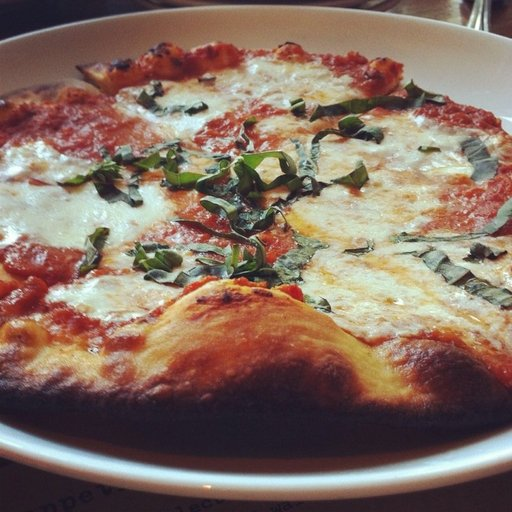

In [75]:
import random  # Import the random module for generating random numbers and making random selections
from PIL import Image  # Import the Image class from the Pillow library
# PIL provides a powerful set of tools for working with images, including opening, manipulating, and saving them.

# Set seed for reproducibility
random.seed(42)  # Setting the seed ensures that the random selections are the same every time the code is run


# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))
# Use the glob method from pathlib.Path to find all JPEG images in any subdirectory two levels deep using */*/*.jpg
# For example, it will match paths like "train/pizza/pizza1.jpg" or "test/steak/steak2.jpg"
# Convert the generator returned by glob into a list for easy access
# if you don't convert the generator to a list, you can only iterate over it once, so random.choice() won't work again after the first iteration

# 2. Get random image path
random_image_path = random.choice(image_path_list)  # Select a random image path from the list for random sampling of images from the dataset


# 3. Get image class from path name
image_class = random_image_path.parent.stem     # Access the parent directory of the image file and get its name (stem) without the file extension
# For example, if the path is "train/pizza/pizza1.jpg", the class is "pizza"

# 4. Open image
img = Image.open(random_image_path)     # Open the image file using Pillow's Image class which provides further processing or analysis of the image

# 5. Print metadata using PIL library
print(f"Random image path: {random_image_path}")    # Display the full path of the randomly selected image

print(f"Image class: {image_class}")    # Display the class/category of the image (e.g., pizza, steak, sushi)

print(f"Image height: {img.height}")    # Display the height of the image in pixels

print(f"Image width: {img.width}")  # Display the width of the image in pixels

img
# In Jupyter notebooks, placing the image object at the end will render and display the image

# image_path_list # uncomment this line if you want to see image paths


#### Explanation of Visualizing an Image


##### 1. Import Modules
```python
import random
from PIL import Image
```
- `random`: This module is used for generating random numbers and making random selections.
- `Image` from `PIL`: The Pillow library (PIL) provides extensive file format support, an efficient internal representation, and fairly powerful image processing capabilities.

##### 2. Set Seed for Reproducibility
```python
random.seed(42)
```
- Setting the seed ensures that the random selections are the same every time the code is run. This is useful for debugging and ensuring consistent results.

##### 3. Get All Image Paths
```python
image_path_list = list(image_path.glob("*/*/*.jpg"))
```
- `image_path.glob("*/*/*.jpg")`: The `glob` method from `pathlib.Path` is used to find all JPEG images in any subdirectory two levels deep. For example, it will match paths like `"train/pizza/pizza1.jpg"` or `"test/steak/steak2.jpg"`.
- `list(...)`: The generator returned by `glob` is converted into a list for easy access. If you don't convert the generator to a list, you can only iterate over it once, so `random.choice()` won't work again after the first iteration.

##### 4. Get Random Image Path
```python
random_image_path = random.choice(image_path_list)
```
- `random.choice(image_path_list)`: Selects a random image path from the list for random sampling of images from the dataset.

##### 5. Get Image Class from Path Name
```python
image_class = random_image_path.parent.stem
```
- `random_image_path.parent`: Returns the parent directory of the `random_image_path`. For example, if the path is `"train/pizza/pizza1.jpg"`, then `parent` will be `"train/pizza"`.
- `random_image_path.parent.stem`: Accesses the name (stem) of the parent directory without the file extension. The stem is essentially the last part of the directory name. For example, if the path is `"train/pizza/pizza1.jpg"`, then `parent.stem` will be `"pizza"`. Combining `.parent` and `.stem` gives you the class/category of the image based on its directory structure.

##### 6. Open Image
```python
img = Image.open(random_image_path)
```
- `Image.open(random_image_path)`: Opens the image file using Pillow's `Image` class, which provides further processing or analysis of the image.

##### 7. Print Metadata Using PIL Library
```python
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
```
- `print(...)`: Displays the full path of the randomly selected image, the class/category of the image (e.g., pizza, steak, sushi), and the dimensions of the image in pixels.

##### 8. Display Image
```python
img
```
- In Jupyter notebooks, placing the image object at the end will render and display the image.

We can do the same with [`matplotlib.pyplot.imshow()`](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.imshow.html), except we have to convert the image to a NumPy array first.

(-0.5, 511.5, 511.5, -0.5)

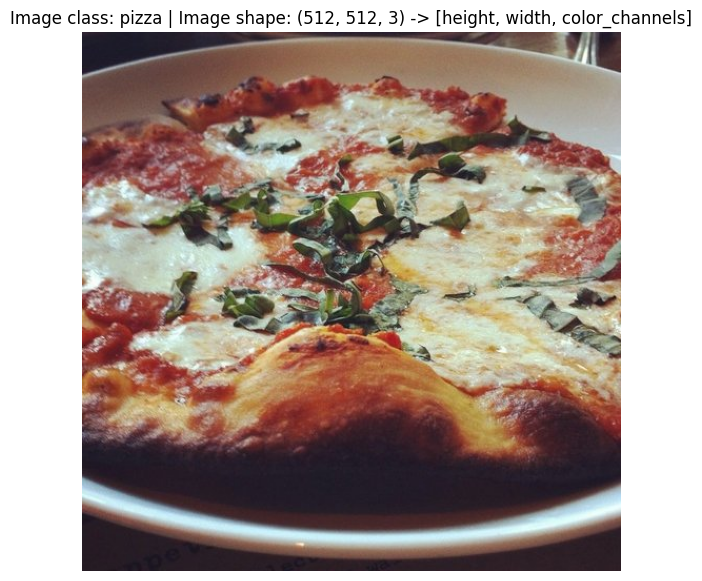

In [76]:
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting images

# Turn the image into a NumPy array
img_as_array = np.asarray(img)

# Plot the image using matplotlib
plt.figure(figsize=(10, 7))  # Set the figure size
plt.imshow(img_as_array)  # Display the image array
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
# Set the plot title with image class and shape details
plt.axis(False)  # Hide the axis for a cleaner look

## 3. Transforming data



Now what if we wanted to load our image data into PyTorch?

Before we can use our image data with PyTorch we need to:

1. Turn it into tensors (numerical representations of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader` for short.

There are several different kinds of pre-built datasets and dataset loaders for PyTorch, depending on the problem you're working on.

| **Problem space** | **Pre-built Datasets and Functions** |
| ----- | ----- |
| **Vision** | [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) |
| **Audio** | [`torchaudio.datasets`](https://pytorch.org/audio/stable/datasets.html) |
| **Text** | [`torchtext.datasets`](https://pytorch.org/text/stable/datasets.html) |
| **Recommendation system** | [`torchrec.datasets`](https://pytorch.org/torchrec/torchrec.datasets.html) |

Since we're working with a vision problem, we'll be looking at `torchvision.datasets` for our data loading functions as well as [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) for preparing our data.

Let's import some base libraries.

In [77]:
import torch
from torch.utils.data import DataLoader  # DataLoader will help us to load the data in batches
from torchvision import datasets, transforms    # datasets is for pre-defined datasets, transforms is for image transformations

### 3.1 Transforming data with `torchvision.transforms`



We've got folders of images but before we can use them with PyTorch, we need to convert them into tensors.

One of the ways we can do this is by using the `torchvision.transforms` module.

`torchvision.transforms` contains many pre-built methods for formatting images, turning them into tensors and even manipulating them for **data augmentation** (the practice of altering data to make it harder for a model to learn, we'll see this later on) purposes .

To get experience with `torchvision.transforms`, let's write a series of transform steps that:
1. Resize the images using [`transforms.Resize()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html#torchvision.transforms.Resize) (from about 512x512 to 64x64, the same shape as the images on the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/)).
2. Flip our images randomly on the horizontal using [`transforms.RandomHorizontalFlip()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizontalFlip.html#torchvision.transforms.RandomHorizontalFlip) (this could be considered a form of data augmentation because it will artificially change our image data. In other words, this artificially increases the diversity of our dataset).
3. Turn our images from a PIL image to a PyTorch tensor using [`transforms.ToTensor()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor).

We can compile all of these steps using [`torchvision.transforms.Compose()`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose).

In [78]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64 in order to be of uniform size for our model input
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

#data_transform(img) # uncomment this to output tensors
data_transform(img).shape # uncomment this to output tensor shape


torch.Size([3, 64, 64])

Now we've got a composition of transforms, let's write a function to try them out on various images.

#### Explanation of `torchvision.transforms`





##### 64x64
- **Reason for 64x64**: Resizing images to 64x64 pixels standardizes the input size, which is essential for training neural networks. This size is a balance between maintaining sufficient detail for the model to learn meaningful features and reducing computational complexity. While 64x64 is somewhat arbitrary, it is commonly used for smaller-scale projects and experiments. Depending on the specific application and dataset, different sizes (e.g., 32x32, 128x128) might be more appropriate.

##### transforms

- **Description**: `transforms` is a module from the `torchvision` library that provides a suite of tools for preprocessing and augmenting image data. It allows you to compose several image transformations into a single pipeline, which can be applied to datasets to prepare them for training neural networks.
- **Usage**: By using `transforms.Compose`, multiple transformations can be chained together to be applied sequentially to each image in the dataset.

##### Resize

- **Function**: `transforms.Resize(size=(64, 64))`
- **Purpose**: Resizes the input image to the specified dimensions (64x64 pixels in this case).
- **Why It's Important**:
  - **Uniformity**: Ensures all images have the same dimensions, which is required for batch processing in neural networks.
  - **Computational Efficiency**: Smaller image sizes reduce the amount of data the model needs to process, speeding up training and inference.
- **Considerations**: Choosing the right size depends on the complexity of the task and the available computational resources. Larger sizes retain more detail but require more processing power.

##### RandomHorizontalFlip

- **Function**: `transforms.RandomHorizontalFlip(p=0.5)`
- **Purpose**: Randomly flips the image horizontally with a probability of 50%.
- **Benefits**:
  - **Data Augmentation**: Introduces variability in the training data, which helps the model generalize better to unseen data.
  - **Robustness**: Makes the model invariant to horizontal orientations of objects, improving its ability to recognize objects regardless of their horizontal placement.
- **Parameters**:
  - `p=0.5`: Sets the probability of flipping an image. A value of 0.5 means there's an equal chance for the image to be flipped or left as is.

##### ToTensor

- **Function**: `transforms.ToTensor()`
- **Purpose**: Converts a PIL Image or NumPy `ndarray` into a PyTorch tensor.
- **Key Actions**:
  - **Scaling**: Transforms pixel values from the range [0, 255] to [0.0, 1.0], which is a common preprocessing step for neural networks.
  - **Dimension Adjustment**: Changes the image shape from (H, W, C) to (C, H, W), as PyTorch expects the channel dimension first.
- **Importance**:
  - **Compatibility**: Prepares image data in a format that PyTorch models can process.
  - **Normalization**: Helps in stabilizing and accelerating the training process by ensuring consistent input scales.


### 3.2 `plot_transformed_images` Function

In the previous section, we applied transformations to a single image. In this section, we will extend this approach to transform multiple images simultaneously.

Transforms play a crucial role in preparing your images for model training and performing data augmentation. By applying a series of transformations to batches of images, we can enhance the diversity of our dataset, improve model generalization, and reduce overfitting.

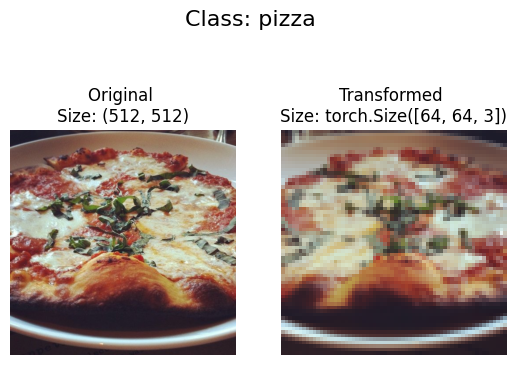

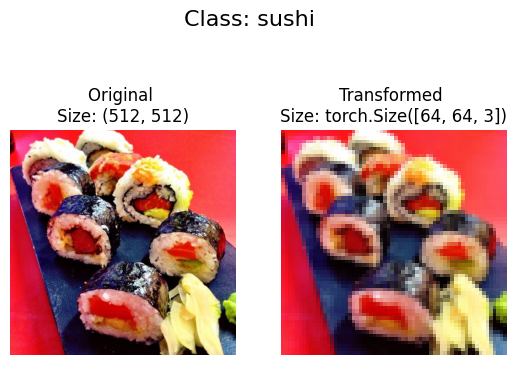

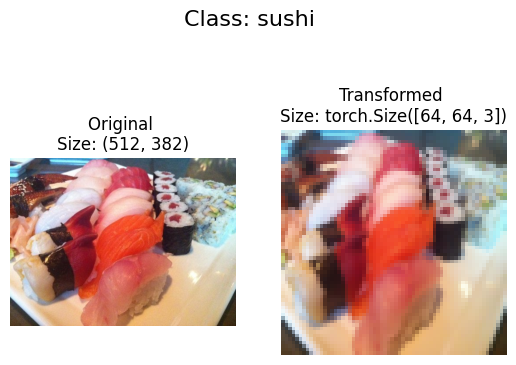

In [79]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)                                       # Set the random seed for reproducibility
    random_image_paths = random.sample(image_paths, k=n)    # Select n random image paths from the list
    for image_path in random_image_paths:                   # Iterate over each image path in the list of 'n' random images
        with Image.open(image_path) as f:                   # Open the image file
            fig, ax = plt.subplots(1, 2)                    # Create a figure with two subplots side by side
            ax[0].imshow(f)                                 # Display the original image in the first subplot
            ax[0].set_title(f"Original \nSize: {f.size}")   # Set the title for the original image subplot
            ax[0].axis("off")                               # Hide the axes for the original image subplot

            # Transform and plot image (original and transformed will be side-by-side)
            # Note: permute() will change shape of image to suit matplotlib

            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)                    # Apply transformations and rearrange dimensions for plotting
            ax[1].imshow(transformed_image)                                      # Display the transformed image in the second subplot
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")    # Set the title for the transformed image subplot
            ax[1].axis("off")                                                    # Hide the axes for the transformed image subplot

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)        # Set the overall title for the figure indicating the image class

plot_transformed_images(         # Plot the transformation
    image_path_list,             # Provide the list of image paths to the function
    transform=data_transform,    # Specify the transformation to apply to images
    n=3                          # Define the number of images
)                                # Call the function to execute the plotting

#### **Explanation of `plot_transformed_images` Function**



The provided code snippet defines a function called `plot_transformed_images`. This function is designed to plot a series of random images from a given list of image paths, apply specified transformations to these images, and display both the original and transformed images side by side. Here's a detailed breakdown:

##### 1. Function Definition
```python
def plot_transformed_images(image_paths, transform, n=3, seed=42):
```
- **Parameters**:
  - `image_paths (list)`: A list of file paths to the target images.
  - `transform (PyTorch Transforms)`: The transformations to apply to the images.
  - `n (int, optional)`: The number of images to plot. Defaults to 3.
  - `seed (int, optional)`: The random seed for reproducibility. Defaults to 42.

##### 2. Set Random Seed
```python
random.seed(seed)
```
- Ensures that the random selections are consistent across different runs by setting a fixed seed value.

##### 3. Select Random Image Paths
```python
random_image_paths = random.sample(image_paths, k=n)
```
- Uses `random.sample` to select `n` unique image paths from the provided list of image paths.

##### 4. Iterate Over Selected Image Paths
```python
for image_path in random_image_paths:
    with Image.open(image_path) as f:
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(f)
        ax[0].set_title(f"Original \nSize: {f.size}")
        ax[0].axis("off")
```
- Opens each selected image file using `Image.open`.
- Creates a figure with two subplots side by side.
- Displays the original image in the first subplot and sets its title to include the image size.
- Hides the axes for better visualization.

##### 5. Apply Transformations and Plot Transformed Image
```python
transformed_image = transform(f).permute(1, 2, 0)
ax[1].imshow(transformed_image)
ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
ax[1].axis("off")
```
- Applies the specified transformations to the image using `transform(f)`.
- Rearranges the dimensions of the transformed image from `[C, H, W]` (PyTorch default) to `[H, W, C]` (Matplotlib format) using `.permute(1, 2, 0)`.
- Displays the transformed image in the second subplot and sets its title to include the new shape.
- Hides the axes for better visualization.

##### 6. Set Overall Title
```python
fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
```
- Sets an overall title for the figure indicating the class of the image, derived from the parent directory name.


The function is then called with the following parameters:
```python
plot_transformed_images(
    image_path_list,
    transform=data_transform,
    n=3
)
```
- `image_path_list`: The list of image paths to be used.
- `transform=data_transform`: The transformation pipeline to apply to each image.
- `n=3`: Specifies that 3 images should be plotted.



Nice!

We've now got a way to convert our images to tensors using `torchvision.transforms`.

We also manipulate their size and orientation if needed (some models prefer images of different sizes and shapes).

Generally, the larger the shape of the image, the more information a model can recover.

For example, an image of size `[256, 256, 3]` will have 16x more pixels than an image of size `[64, 64, 3]` (`(256*256*3)/(64*64*3)=16`).

However, the tradeoff is that more pixels requires more computations.

> **Exercise:** Try commenting out one of the transforms in `data_transform` and running the plotting function `plot_transformed_images()` again, what happens?

## 4. Option 1: Loading Image Data Using [`ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder)




Alright, time to turn our image data into a `Dataset` capable of being used with PyTorch.

Since our data is in standard image classification format, we can use the class [`torchvision.datasets.ImageFolder`](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html#torchvision.datasets.ImageFolder).

`ImageFolder` is a convenient class provided by `torchvision.datasets` that allows you to load an image dataset arranged in a specific way. The directory structure should have subdirectories for each class, where the name of each subdirectory corresponds to the class label.



By using `ImageFolder`, you don't need to write custom code to load your images and labels. You simply pass the file path of a target image directory, and it automatically infers the classes based on the subdirectory names. We can also pass a series of transforms we'd like to perform on our images.

Let's test it out on our data folders `train_dir` and `test_dir` passing in `transform=data_transform` to turn our images into tensors.

In [80]:
# Import the 'datasets' module from 'torchvision', which provides easy access to various image datasets
from torchvision import datasets

# Create a training dataset using ImageFolder
train_data = datasets.ImageFolder(root=train_dir,                # Specify the path to the root directory containing training images
                                                                 # The directory should have subdirectories for each class, each containing respective images
                                  transform=data_transform,      # Define a series of transformations to apply to the images
                                                                 # This can include resizing, normalization, data augmentation, etc.
                                  target_transform=None)         # (Optional) Define a transformation for the labels/target
                                                                 # For example, converting class names to integer labels
                                                                 # Set to 'None' if no transformation is needed.

test_data = datasets.ImageFolder(root=test_dir,                  # Specify the path to the root directory containing testing images
                                 transform=data_transform)       # Define a series of transformations to apply to the images)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

#### **`ImageFolder` Functionality**




In machine learning and deep learning, having a well-structured dataset is crucial for training models effectively. PyTorch, a popular open-source library for deep learning, provides several utilities to handle datasets easily. One such utility is the `datasets` module from `torchvision`, which simplifies the process of loading and transforming image datasets.

##### 1. Importing the Datasets Module

```python
from torchvision import datasets
```

- The first step is to import the `datasets` module from `torchvision`. This module provides a variety of pre-loaded datasets, such as ImageNet, CIFAR-10, MNIST, etc., and also allows for easy creation of custom datasets using classes like `ImageFolder`.

##### 2. Creating a Training Dataset Using ImageFolder

```python
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)
```

- Here, we are creating a training dataset using the `ImageFolder` class. This class is particularly useful for image classification tasks where images are organized into subdirectories named after their respective classes.

###### Parameters

- **root**:
  - Specifies the path to the root directory containing the training images.
  - The directory structure should be such that each subdirectory corresponds to a different class, and within each subdirectory, there are images belonging to that class. For example:
    ```
    train_dir/
        class1/
            img001.jpg
            img002.jpg
            ...
        class2/
            img001.jpg
            img002.jpg
            ...
        ...
    ```

- **transform**:
  - This parameter accepts a series of transformations to apply to the images before they are fed into the model.
  - These transformations can include resizing, cropping, flipping, normalization, and other forms of data augmentation. They help in improving the generalization of the model by exposing it to more varied inputs during training.
  - Example transformation pipeline using `torchvision.transforms`:
    ```python
    import torchvision.transforms as transforms

    data_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    ```

- **target_transform**:
  - This parameter is optional and allows for transformations to be applied to the labels or target values.
  - For example, if you need to convert class names into integer labels, this would be where you define that transformation.
  - If no specific transformation is needed for the targets, it can be set to `None` (as shown in the code snippet).

By using `ImageFolder`, PyTorch automatically loads images from the specified directory structure and applies the given transformations. This makes the process of preparing datasets more efficient and less error-prone, enabling researchers and developers to focus more on model development and experimentation rather than dataset management.

##### 3. Creating a Testing Dataset Using ImageFolder

```python
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)
```

Similarly, we create a testing dataset using the `ImageFolder` class. The structure and parameters are very similar to those used for the training dataset.

###### Parameters

- **root**:
  - Specifies the path to the root directory containing the testing images.
  - Similar to the training dataset, the directory should have subdirectories for each class, each containing respective images. For example:
    ```
    test_dir/
        class1/
            img001.jpg
            img002.jpg
            ...
        class2/
            img001.jpg
            img002.jpg
            ...
        ...
    ```

- **transform**:
  - This parameter accepts the same series of transformations applied to the images as in the training dataset.
  - It ensures that the testing images undergo the same preprocessing steps, maintaining consistency between the training and testing datasets.

##### 4. Why Don't We Specify `target_transform` for Test Data?

The decision not to specify a `target_transform` for the test data is based on several considerations:

1. **Consistency**:
   - During training, the model learns to map input images to specific class labels. The same mapping should be used during testing to ensure that the model's performance is evaluated consistently.
   - If different transformations are applied to the target labels in the test dataset, it could lead to discrepancies and make it difficult to interpret the results accurately.

2. **Simplicity**:
   - By not specifying a `target_transform` for the test data, we maintain simplicity and avoid potential errors that might arise from applying inconsistent transformations.
   - The default behavior of `ImageFolder` is to convert class names into integer labels based on the directory structure, which is consistent with how the training dataset is handled.

3. **Standardization**:
   - In many cases, the target labels are already in a standardized format (e.g., integer labels) that does not require additional transformation.
   - If any specific transformation is needed for the target labels, it should be applied consistently to both the training and testing datasets to ensure fairness and accuracy in evaluation.

4. **Best Practices**:
   - Best practices in machine learning emphasize the importance of consistency between training and testing datasets.
   - By not specifying a `target_transform` for the test data, we adhere to these best practices, ensuring that the model is evaluated under the same conditions it was trained on.

##### 5. Summary

- **Importing**: Start by importing the `datasets` module from `torchvision`.
- **ImageFolder**: Utilize this class for image classification tasks where images are organized into subdirectories named after their classes.
- **Parameters**:
  - **root**: Path to the root directory containing training or testing images.
  - **transform**: Series of transformations applied to the images.
  - **target_transform**: Optional transformations applied to the labels/targets.

This setup provides a flexible and efficient way to handle image datasets in PyTorch, facilitating both research and production use cases. The code snippet demonstrates how to create both training and testing datasets using `ImageFolder`, ensuring that the same preprocessing steps are applied consistently across both datasets.

```python
train_data, test_data
```

This final line returns the created `train_data` and `test_data` objects, which can be used for further processing, such as loading data into dataloaders or training a model.

By not specifying a `target_transform` for the test data, we ensure consistency and maintain best practices in dataset handling, leading to more reliable and interpretable evaluation of the model's performance.

#### **Inspect the Datasets**



It looks like PyTorch has registered our `Dataset`'s.

Let's inspect them by checking out the `classes` and `class_to_idx` attributes as well as the lengths of our training and test sets.

##### 1. `.classes` Attribute

- The `.classes` attribute from the `ImageFolder` class provides a list of class names in the dataset. Here is how you can access it:

```python
class_names = train_data.classes  # .classes is from ImageFolder and provides the class names in the dataset
class_names
```

##### 2. `.class_to_idx` Attribute

- The `.class_to_idx` attribute from the `ImageFolder` class provides a dictionary mapping each class name to its respective index. Here is how you can access it:

```python
# Get class names as a dictionary
class_dict = train_data.class_to_idx  # .class_to_idx is from ImageFolder and provides the class names and their respective indices
class_dict
```

For more information, you can refer to the [PyTorch `ImageFolder` documentation](https://pytorch.org/vision/stable/datasets.html#imagefolder).

#### **class_names and class_dict**

In [81]:
class_names = train_data.classes  # .classes is from ImageFolder and provides the class names in the dataset
class_names

['pizza', 'steak', 'sushi']

In [82]:
# Get class names as a dictionary
class_dict = train_data.class_to_idx  # .class_to_idx is from ImageFolder and provides the class names and their respective indices
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [83]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

Nice! Looks like we'll be able to use these to reference for later.

How about our images and labels?

How do they look?

We can index on our `train_data` and `test_data` `Dataset`'s to find samples and their target labels.

In [84]:
# Index on the train_data Dataset to get a single image and its label
img, label = train_data[0][0], train_data[0][1]  # Get the first image and its label from the training dataset
print(f"Image tensor:\n{img}")  # Display the image tensor
print(f"Image label: {label}")   # Display the image label
print(f"Image datatype: {img.dtype}")  # Display the image datatype
print(f"Image label: {label}")  # Display the image label
print(f"Label datatype: {type(label)}")  # Display the datatype of the label

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

#### **Inspecting a Single Image and Label from the Dataset**



In this section, we will inspect a single image and its corresponding label from the training dataset to understand their structure and data types.

##### 1. Accessing an Image and Its Label

- We use indexing on the `train_data` dataset to retrieve the first image and its label. The `ImageFolder` class allows us to access individual samples using this method.

```python
img, label = train_data[0][0], train_data[0][1]  # Get the first image and its label from the training dataset
```

##### 2. Displaying the Image Tensor

- We print the image tensor to understand its structure. The image is represented as a PyTorch tensor.

```python
print(f"Image tensor:\n{img}")  # Display the image tensor
```

##### 3. Displaying the Image Label

- We print the label associated with the image to see what it represents.

```python
print(f"Image label: {label}")   # Display the image label
```

##### 4. Displaying the Image Datatype

- We check the datatype of the image tensor to ensure it is in the expected format, typically `torch.FloatTensor` for images.

```python
print(f"Image datatype: {img.dtype}")  # Display the image datatype
```

##### 5. Displaying the Label Datatype

- We also check the datatype of the label to confirm its type, which is usually an integer (`int`) representing the class index.

```python
print(f"Label datatype: {type(label)}")  # Display the datatype of the label
```

Our images are now in the form of a tensor (with shape `[3, 64, 64]`) and the labels are in the form of an integer relating to a specific class (as referenced by the `class_to_idx` attribute).

How about we plot a single image tensor using `matplotlib`?

We'll first have to to permute (rearrange the order of its dimensions) so it's compatible.

Right now our image dimensions are in the format `CHW` (color channels, height, width) but `matplotlib` prefers `HWC` (height, width, color channels).

Original image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Post-permutation shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

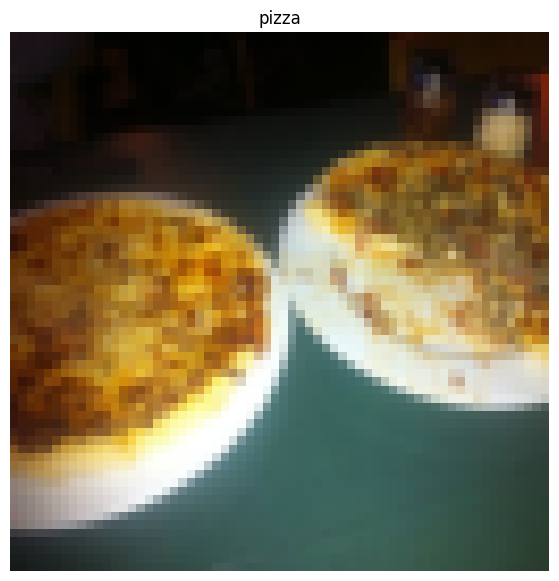

In [85]:
# Rearrange the order dimensions
img_permute = img.permute(1, 2, 0)  # Rearrange the dimensions of the image tensor for plotting

# Print out different shapes
print(f"Original image shape: {img.shape} -> [color_channels, height, width]")  # Display the original shape of the image tensor
print(f"Post-permutation shape: {img_permute.shape} -> [height, width, color_channels]")  # Display the shape of the permuted image

# Plot the image
plt.figure(figsize=(10, 7))  # Set the figure size
plt.imshow(img_permute)      # Display the image tensor
plt.axis("off")              # Hide the axis
plt.title(class_names[label])  # Set the title of the plot to the class name of the image

Notice the image is now more pixelated (less quality).

This is due to it being resized from `512x512` to `64x64` pixels.

The intuition here is that if you think the image is harder to recognize what's going on, chances are a model will find it harder to understand too.

### **4.1 Turn loaded images (Datasets) into `DataLoader`'s**




Now that we have our images as PyTorch `Dataset` objects, let's convert them into `DataLoader` objects using [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

#### What is DataLoader and why use it?

- Converting `Dataset` objects to `DataLoader` objects makes them iterable. This allows a model to go through and learn the relationships between samples and targets (features and labels).
- `DataLoader` handles batching, shuffling, and loading data in parallel using multiple subprocesses.

#### Setting Up DataLoader

We'll use a simple configuration with:
- `batch_size=1`: Each batch will contain one sample.
- `num_workers=1`: One subprocess will be used to load the data.

#### What is `num_workers`?

- `num_workers` defines how many subprocesses will be created to load your data.
- Think of it like this: the higher value `num_workers` is set to, the more compute power PyTorch will use to load your data.
- Personally, I usually set it to the total number of CPUs on my machine using Python's [`os.cpu_count()`](https://docs.python.org/3/library/os.html#os.cpu_count).
  - This ensures the `DataLoader` recruits as many cores as possible to load data efficiently.



#### Additional Parameters

- There are more parameters you can explore in the [PyTorch `DataLoader` documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).
  - For example, `shuffle=True` to shuffle the data at every epoch.
  - `pin_memory=True` to speed up data transfer to GPU if available.

By using `DataLoader`, we can efficiently manage and load our dataset in a way that is suitable for training machine learning models.

In [86]:
# Turn train and test data into DataLoaders
import os
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data,  # Load the training data
                              batch_size=1,        # Load images one by one
                              #num_workers=os.cpu_count(),   # Alternatively, use all number of CPU cores available
                              num_workers=1,       # Uses 1 CPU core
                              shuffle=True)        # Shuffle the data for training

test_dataloader = DataLoader(dataset=test_data,    # Load the testing data
                             batch_size=1,         # Load images one by one
                             num_workers=1,        # Use the number of CPU cores available
                             shuffle=False)        # Do not shuffle the data for testing

len(train_dataloader), len(test_dataloader)

(225, 75)

Wonderful!

Now our data is iterable.

Let's try it out and check the shapes.

In [87]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


#### **Inspecting a Batch from the DataLoader**




To understand the structure of the data being fed into the model, we can inspect a single batch from the `DataLoader`.

##### Why Do This?

- **Understanding Data Shape**: By examining the shape of the image and label tensors, you can verify that the data is in the expected format.
- **Batch Size Verification**: It allows you to confirm that the `batch_size` parameter is set correctly and understand how the data is batched.
- **Debugging**: Helps in identifying any issues with data loading or preprocessing.

##### What are Iterators and Iterables?

- **Iterable**: An object that can return its members one at a time. Examples include lists, tuples, dictionaries, sets, and custom objects that implement the `__iter__()` method.
- **Iterator**: An object that represents a stream of data. It implements two methods: `__iter__()` (returns the iterator object itself) and `__next__()` (returns the next item from the sequence).

##### How do Iterators and Iterables Interact with `train_dataloader`?

- The `DataLoader` is an iterable that provides batches of data.
- When you call `iter(train_dataloader)`, it returns an iterator over the `DataLoader`.
- The `next()` function retrieves the next batch from this iterator.

##### Example Code

```python
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")
```

##### Explanation

- `iter(train_dataloader)`: Creates an iterator over the `DataLoader`.
- `next(iter(train_dataloader))`: Retrieves the next batch from the iterator.
- `img.shape`: Provides the dimensions of the image tensor, which should match `[batch_size, color_channels, height, width]`.
- `label.shape`: Provides the dimensions of the label tensor, which should match `[batch_size]`.

This inspection is crucial for ensuring that your data is correctly formatted and ready for training.

We could now use these `DataLoader`'s with a training and testing loop to train a model.

But before we do, let's look at another option to load images (or almost any other kind of data).

## 5. Option 2: Loading Image Data with a Custom `Dataset`


# 04. PyTorch Custom Datasets

In the last notebook, [notebook 03](https://www.learnpytorch.io/03_pytorch_computer_vision/), we looked at how to build computer vision models on an in-built dataset in PyTorch (FashionMNIST).

The steps we took are similar across many different problems in machine learning.

Find a dataset, turn the dataset into numbers, build a model (or find an existing model) to find patterns in those numbers that can be used for prediction.

PyTorch has many built-in datasets used for a wide number of machine learning benchmarks, however, you'll often want to use your own **custom dataset**.

## What is a custom dataset?

A **custom dataset** is a collection of data relating to a specific problem you're working on.

In essence, a **custom dataset** can be comprised of almost anything.

For example, if we were building a food image classification app like [Nutrify](https://nutrify.app), our custom dataset might be images of food.

What if a pre-built `Dataset` creator like [`torchvision.datasets.ImageFolder()`](https://pytorch.org/vision/stable/datasets.html#torchvision.datasets.ImageFolder) didn't exist?

Or one for your specific problem didn't exist?

Well, you could build your own.

But wait, what are the pros and cons of creating your own custom way to load `Dataset`'s?

| Pros of creating a custom `Dataset` | Cons of creating a custom `Dataset` |
| ----- | ----- |
| Can create a `Dataset` out of almost anything. | Even though you *could* create a `Dataset` out of almost anything, it doesn't mean it will work. |
| Not limited to PyTorch pre-built `Dataset` functions. | Using a custom `Dataset` often results in writing more code, which could be prone to errors or performance issues. |

To see this in action, let's work towards replicating `torchvision.datasets.ImageFolder()` by subclassing `torch.utils.data.Dataset` (the base class for all `Dataset`'s in PyTorch).

We'll start by importing the modules we need:
* Python's `os` for dealing with directories (our data is stored in directories).
* Python's `pathlib` for dealing with filepaths (each of our images has a unique filepath).
* `torch` for all things PyTorch.
* PIL's `Image` class for loading images.
* `torch.utils.data.Dataset` to subclass and create our own custom `Dataset`.
* `torchvision.transforms` to turn our images into tensors.
* Various types from Python's `typing` module to add type hints to our code.

> **Note:** You can customize the following steps for your own dataset. The premise remains: write code to load your data in the format you'd like it.

#### Subclassing `torch.utils.data.Dataset`

All datasets that represent a map from keys to data samples should subclass `torch.utils.data.Dataset`. A "map" in this context means a collection of items where each item can be accessed by an index or a key. The "keys" here are typically integers representing the position of the data sample in the dataset.

##### What is an Item?

An **item** in a dataset refers to a single piece of data, such as an image and its corresponding label in a classification task. For example, in an image classification dataset, an item would be a tuple containing an image tensor and its associated class label.

To create your own custom dataset, you need to override two essential methods:
- `__getitem__(self, idx)`: This method should return the data at index `idx`. It is used when you access an item using square brackets (e.g., `dataset[idx]`).
- `__len__(self)`: This method should return the number of samples in your dataset. While not strictly required, it's a good practice to implement this so that functions like `len(dataset)` work as expected.

For more information on subclassing `torch.utils.data.Dataset`, you can refer to [the official PyTorch documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset).

> **Note:** You can customize the following steps for your own dataset. The premise remains: write code to load your data in the format you'd like it.

In [88]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

Remember how our instances of `torchvision.datasets.ImageFolder()` allowed us to use the `classes` and `class_to_idx` attributes?

In [89]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names


#### `os.scandir()` and `os.DirEntry`

The `os.scandir(path)` function is a powerful tool in Python for efficiently iterating over the entries in a directory. It returns an iterator of `os.DirEntry` objects, each representing a file or subdirectory within the specified directory path. This method is more efficient than `os.listdir()` because it does not retrieve file metadata unless explicitly requested.

##### What is `os.DirEntry`?

- **`os.DirEntry`**: An object provided by `os.scandir(path)` that contains information about a directory entry (file or subdirectory).
  - **`.name`**: The name of the directory entry (e.g., a subdirectory or a file) as a string.
  - **`.path`**: The full path to the directory entry. This is equivalent to `os.path.join(scandir_path, entry.name)`.
  - **`.is_dir()`**: A method that returns `True` if the entry is a directory and `False` otherwise.
  - **`.is_file()`**: A method that returns `True` if the entry is a file and `False` otherwise.
  - **`.inode()`**: Returns the inode number of the directory entry, if available (not available on Windows).
  - **`.stat(follow_symlinks=True)`**: Returns an object similar to what you would get from `os.stat()`, which contains detailed information about the file or directory. The optional argument `follow_symlinks` specifies whether symbolic links should be followed.




For more detailed information on `os.scandir()` and `os.DirEntry`, you can refer to the [Python documentation](https://docs.python.org/3/library/os.html#os.scandir).

This will help in understanding how these functions and objects work together to efficiently handle directory contents.

In [90]:
# Setup path for target directory
target_directory = train_dir                # Get path to training directory
target_directory                            # Display the directory path
print(f"Target dir: {target_directory}")    # Print formatted string showing directory path

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])  # Get sorted list of subfolder names

Target dir: data/pizza_steak_sushi/train


#### **`os.scandir()` Syntax**



##### Overview
The following code sets up a path to a target directory, prints it out, and then retrieves the class names from within that directory.

##### Setting Up Path for Target Directory
```python
target_directory = train_dir
```
- **`target_directory`**: This is a variable name chosen to store the path to the directory containing your dataset.
- **`= train_dir`**: The variable `train_dir` (which should be defined earlier in the notebook) holds the path to the training data directory. Here, we assign that value to `target_directory`.

##### Printing Target Directory Path
```python
print(f"Target dir: {target_directory}")
```
- **`print()`**: This function outputs messages to the console.
- **`f-string (formatted string literals)`**: The `f` before the opening quote of the string indicates that it's an f-string, which allows you to embed expressions inside string literals using curly braces `{}`.
- **`{target_directory}`**: Inside the curly braces is the variable name whose value will be substituted into the string when printed.

##### Getting Class Names from Target Directory
```python
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
```
- **`os.scandir(target_directory)`**: This function returns an iterator of `DirEntry` objects corresponding to the entries in the directory given by `target_directory`. It's a more efficient way to iterate over directories compared to using `os.listdir()`.
- **`list()`**: Converts the iterator returned by `os.scandir()` into a list.
- **`[entry.name for entry in ...]`**: A list comprehension that iterates over each `DirEntry` object (`entry`) and collects its name attribute (`entry.name`). This typically gives you the names of subdirectories or files within the target directory, which are treated as class names.
- **`sorted()`**: Sorts the list of class names alphabetically. Sorting helps in ensuring consistency and predictability when accessing these classes later in your code.
- **`= class_names_found`**: Assigns the sorted list of class names to a new variable named `class_names_found`.

##### Summary
This block of code is crucial for setting up paths and identifying the categories (or classes) present in your dataset directory. It prepares your environment to handle different classes of data, which is essential for training custom models.

Excellent!

How about we turn it into a full function?

In [91]:
# Make function to find classes in a target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class folder names in a target directory.

    Assumes target directory is in standard image classification format.

    Args:
        directory (str): Target directory to load classnames from.

    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name: idx...))

    Example:
        find_classes("food_images/train")
        >>> (["class_1", "class_2"], {"class_1": 0, ...})
    """

    # 1. Get the class names by scanning the target directory
    # Use a list comprehension to extract the .name attribute of each entry that is a directory
    classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])

    # 2. Raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"No class folders found in {directory}.")

    # 3. Create a dictionary of index labels (computers prefer numerical rather than string labels)
    # Use enumerate to create a mapping from class name to its corresponding index
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

    return classes, class_to_idx

Looking good!

Now let's test out our `find_classes()` function.

In [92]:
find_classes(target_directory)  # Test the function

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`




Now we're ready to build our own custom `Dataset`.

We'll build one to replicate the functionality of `torchvision.datasets.ImageFolder()`.

This will be good practice, plus, it'll reveal a few of the required steps to make your own custom `Dataset`.

It'll be a fair bit of a code... but nothing we can't handle!

Let's break it down:
1. Subclass `torch.utils.data.Dataset`.
2. Initialize our subclass with a `targ_dir` parameter (the target data directory) and `transform` parameter (so we have the option to transform our data if needed).
3. Create several attributes for `paths` (the paths of our target images), `transform` (the transforms we might like to use, this can be `None`), `classes` and `class_to_idx` (from our `find_classes()` function).
4. Create a function to load images from file and return them, this could be using `PIL` or [`torchvision.io`](https://pytorch.org/vision/stable/io.html#image) (for input/output of vision data).
5. Overwrite the `__len__` method of `torch.utils.data.Dataset` to return the number of samples in the `Dataset`, this is recommended but not required. This is so you can call `len(Dataset)`.
6. Overwrite the `__getitem__` method of `torch.utils.data.Dataset` to return a single sample from the `Dataset`, this is required.

Let's do it!

In [93]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset): # Inherit from the Dataset class that is provided by PyTorch for custom datasets
    # 2. Initialize our custom dataset
    def __init__(self,              # Initialize the class
                 targ_dir: str,     # Initialize with the target directory to load images from
                 transform=None):

        # 3. Create class attributes
        # Get all of the image paths and their corresponding labels
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))  # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = find_classes(targ_dir)    # Use the find_classes function we created earlier to get the class names and their indices

    # 4. Create a function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path =self.paths[index]  # Get the image path at the specified index
        return Image.open(image_path)

    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples in the dataset"
        return len(self.paths)  # Return the total number of image paths

    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:  # Replicates behavior of the original ImageFolder dataset, returning a tuple of img and label
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)    # from step 4, load the image at the specified index
        class_name = self.paths[index].parent.name  # Get the class name from the parent directory of the image path
        class_idx = self.class_to_idx[class_name]   # Get the class index from the class name

        # Transform, if necessary
        if self.transform:
            return self.transform(img), class_idx   # return transformed data, label (X, y)
        else:
            return img, class_idx                   # return untransformed data, label (X, y)

Woah! A whole bunch of code to load in our images.

This is one of the downsides of creating your own custom `Dataset`'s.

However, now we've written it once, we could move it into a `.py` file such as `data_loader.py` along with some other helpful data functions and reuse it later on.

Before we test out our new `ImageFolderCustom` class, let's create some transforms to prepare our images.


#### ImageFolderCustom Explanation



##### Step-by-Step Breakdown

###### Import Necessary Modules
```python
from torch.utils.data import Dataset
```
- **Explanation**: This imports the `Dataset` class from the `torch.utils.data` module, which is a base class for creating custom datasets in PyTorch.

###### Subclassing `torch.utils.data.Dataset`
```python
class ImageFolderCustom(Dataset):
```
- **Explanation**: We define a new class named `ImageFolderCustom` that inherits from the `Dataset` class. This allows us to create a custom dataset with specific functionality.

##### Initialize Our Custom Dataset
```python
def __init__(self, targ_dir: str, transform=None):
```
- **Explanation**: The `__init__` method is the constructor for our class. It initializes the object with necessary attributes.
  - `targ_dir: str`: This parameter specifies the target directory containing images organized in subdirectories by class.
  - `transform=None`: This optional parameter allows us to pass transformations that will be applied to the images.

##### Create Class Attributes
```python
self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
```
- **Explanation**:
  - `self.paths` is an attribute that stores a list of image file paths in the target directory.
  - `pathlib.Path(targ_dir).glob("*/*.jpg")`: This uses the `glob` method to find all `.jpg` files in subdirectories of the target directory. The pattern `"*/*.jpg"` means any file ending with `.jpg` in any subdirectory.

```python
self.transform = transform
```
- **Explanation**:
  - `self.transform` stores the transformation function (if provided) that will be applied to each image.

```python
self.classes, self.class_to_idx = find_classes(targ_dir)
```
- **Explanation**:
  - `self.classes`: A list of class names.
  - `self.class_to_idx`: A dictionary mapping class names to their corresponding indices.
  - `find_classes(targ_dir)`: This function is assumed to be defined elsewhere and returns the class names and their indices based on the directory structure.

##### Create a Function to Load Images
```python
def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)
```
- **Explanation**:
  - `load_image` is a method that loads and returns an image from the specified index.
  - `index: int`: The index of the image in the `self.paths` list.
  - `image_path = self.paths[index]`: Retrieves the file path of the image at the given index.
  - `Image.open(image_path)`: Opens and returns the image using the `PIL` library.

##### Overwrite the `__len__()` Method
```python
def __len__(self) -> int:
    "Returns the total number of samples in the dataset"
    return len(self.paths)
```
- **Explanation**:
  - The `__len__` method returns the total number of images (or samples) in the dataset.
  - `return len(self.paths)`: Returns the length of the list `self.paths`, which is the number of image files.

##### Overwrite the `__getitem__()` Method
```python
def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]
    
    if self.transform:
        return self.transform(img), class_idx
    else:
        return img, class_idx
```
- **Explanation**:
  - The `__getitem__` method retrieves a single sample from the dataset given an index.
  - `index: int`: The index of the image to retrieve.
  - `img = self.load_image(index)`: Loads the image at the specified index using the `load_image` method.
  - `class_name = self.paths[index].parent.name`: Retrieves the class name from the parent directory of the image path.
  - `class_idx = self.class_to_idx[class_name]`: Converts the class name to its corresponding index.
  - If a transformation is provided (`if self.transform`), it applies the transformation to the image and returns the transformed image along with the class index. Otherwise, it returns the untransformed image and class index.

#### Transform our raw jpg images into tensors

In [94]:
# Augment train data

# from torchvision.transforms # uncomment this if you haven't imported it yet

train_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only perform a resize and transform to tensor
test_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

Now comes the moment of truth!

Let's turn our training images (contained in `train_dir`) and our testing images (contained in `test_dir`) into `Dataset`'s using our own `ImageFolderCustom` class.

In [95]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7a4882445090>,
 <__main__.ImageFolderCustom at 0x7a4903f54190>)

Hmm... no errors, did it work?

Let's try calling `len()` on our new `Dataset`'s and find the `classes` and `class_to_idx` attributes.

In [96]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [97]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

`len(test_data_custom) == len(test_data)` and `len(test_data_custom) == len(test_data)` Yes!!!

It looks like it worked.

We could check for equality with the `Dataset`'s made by the `torchvision.datasets.ImageFolder()` class too.

In [98]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True



#### Explanation

By checking the length of our custom dataset (`train_data_custom`) against the built-in dataset (`train_data`), as well as comparing the `classes` and `class_to_idx` attributes, we ensure that our custom dataset is correctly implemented. These checks confirm that:

1. **Length**: The number of samples in both datasets are identical.
2. **Classes**: The class names associated with each sample match between the two datasets.
3. **Class Index Mapping**: The mapping from class names to their respective indices is consistent.

This validation step is crucial because any discrepancy could indicate an error in our custom dataset implementation, leading to incorrect model training and evaluation results.

### 5.3 Create a function to display random images



You know what time it is!

Time to put on our data explorer's hat and *visualize, visualize, visualize!*

Let's create a helper function called `display_random_images()` that helps us visualize images in our `Dataset'`s.

Specifically, it'll:
1. Take in a `Dataset` and a number of other parameters such as `classes` (the names of our target classes), the number of images to display (`n`) and a random seed.
2. To prevent the display getting out of hand, we'll cap `n` at 10 images.
3. Set the random seed for reproducible plots (if `seed` is set).
4. Get a list of random sample indexes (we can use Python's `random.sample()` for this) to plot.
5. Setup a `matplotlib` plot.
6. Loop through the random sample indexes found in step 4 and plot them with `matplotlib`.
7. Make sure the sample images are of shape `HWC` (height, width, color channels) so we can plot them.

In [99]:
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    # 2. Adjust display if n too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display purposes, n shouldn't be larger than 10; setting to 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k = n)   # .sample is from the random module

    # 5. Setup plot
    plt.figure(figsize=(16, 8))

    # 6. Loop through samples and display random samples
    for i, targ_sample in enumerate(random_samples_idx): # enumerate means we get both the index and the value
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # Adjust image tensor shape for plotting: [C, H, W] -> [H, W, C]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class {classes[targ_label]}"
            if display_shape:
                title += f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

What a good looking function!

Let's test it out first with the `Dataset` we created with `torchvision.datasets.ImageFolder()`.

#### Explanation of `display_random_images()`



##### Line 1-3
```python
# 1. Take in a Dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
```
- **Function Name:** `display_random_images` - This function is designed to visualize random images from a given dataset.
- **Parameters:**
  - `dataset`: A PyTorch Dataset object which contains the images and labels.
  - `classes`: An optional list of class names. If provided, these will be used as titles for the plots.
  - `n`: The number of random samples to display. Defaults to 10.
  - `display_shape`: A boolean indicating whether to include the shape information of the images in the plot titles. Defaults to True.
  - `seed`: An optional seed value for the random number generator, which ensures reproducibility.


##### Line 5-9
```python
# 2. Adjust display if n too high
if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
```
- **Condition:** Checks if `n` (number of images to display) is greater than 10.
- **Adjustments:**
  - If true, sets `n` to 10 to limit the number of displayed images.
  - Sets `display_shape` to False because displaying shape information for more than 10 images could clutter the plot.
  - Prints a message informing the user about these adjustments.


##### Line 12-13
```python
# 3. Set random seed
if seed:
    random.seed(seed)
```
- **Condition:** Checks if `seed` is provided.
- **Action:** If a seed is provided, it sets the seed for Python's built-in random module to ensure that the same images are selected each time the function runs with the same seed.


##### Line 16
```python
# 4. Get random sample indexes
random_samples_idx = random.sample(range(len(dataset)), k=n)
```
- **Action:** Uses `random.sample` to select `n` unique random indices from the range of dataset length. This gives us a list of indices pointing to random samples in the dataset.
- **Explanation:**
  - `range(len(dataset))`: Generates a sequence of numbers from 0 to the length of the dataset minus one.
  - `random.sample(...)`: Randomly selects `n` unique elements from this sequence, ensuring that each index is picked only once.


##### Line 19
```python
# 5. Setup plot
plt.figure(figsize=(16, 8))
```
- **Action:** Creates a new matplotlib figure with a specified size (16x8 inches) to accommodate `n` subplots side by side.


##### Line 24-25
```python
for i, targ_sample in enumerate(random_samples_idx): # enumerate means we get both the index and the value
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]  
```
- **`enumerate(random_samples_idx)`:**
  - The `enumerate` function is used to loop over the `random_samples_idx` list while keeping track of both the index (`i`) and the value (`targ_sample`).
  - For example, if `random_samples_idx` is `[3, 1, 7]`, `enumerate` will produce pairs like `(0, 3)`, `(1, 1)`, and `(2, 7)`.

- **`dataset[targ_sample][0], dataset[targ_sample][1]`:**
  - `dataset[targ_sample]`: Accesses the sample at the index specified by `targ_sample` from the dataset.
    - The dataset is an instance of a PyTorch `Dataset`, which typically returns a tuple containing the image and its corresponding label when indexed.
    - For example, `dataset[3]` might return `(image_3, label_3)`.
  - `[0]` and `[1]`: These are used to access specific elements from the tuple returned by `dataset[targ_sample]`.
    - `[0]`: Accesses the first element of the tuple, which is the image (`targ_image`).
    - `[1]`: Accesses the second element of the tuple, which is the label (`targ_label`).

- **Unpacking:**
  - `targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]`: This line unpacks the tuple returned by `dataset[targ_sample]` into two separate variables.
    - `targ_image` will hold the image data.
    - `targ_label` will hold the label associated with that image.

##### Line 28-37
```python
    # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [height, width, color_channels]
    targ_image_adjust = targ_image.permute(1, 2, 0)

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
        title = f"class: {classes[targ_label]}"
        if display_shape:
            title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)
```
- **Loop:** Iterates over the list of random sample indices using `enumerate`, which provides both the index (`i`) and the value (`targ_sample`).
  - `targ_sample`: Represents an index from the dataset.
  - `i`: The iteration counter used for plotting.
  - **Explanation:**
    - `enumerate(random_samples_idx)`: Generates pairs of `(index, value)` where `index` is the loop counter starting from 0 and `value` is each element in `random_samples_idx`.
    - Both `targ_sample` (the dataset index) and `i` (the plot position) are needed:
      - `targ_sample`: To access specific images and labels from the dataset.
      - `i+1`: To correctly place each image in its respective subplot position within the figure.
- **Image Retrieval:** Retrieves the image and label at the current `targ_sample` index.
- **Shape Adjustment:** PyTorch images are typically in [color_channels, height, width] format. Uses `.permute(1, 2, 0)` to convert this to [height, width, color_channels], which is required for displaying with matplotlib's `imshow`.
- **Plotting:**
  - Creates a subplot within the figure using `plt.subplot(1, n, i+1)`, where each image will be displayed side by side in one row.
  - Displays the image using `plt.imshow(targ_image_adjust)`.
  - Hides the axis with `plt.axis("off")` to make the plot cleaner.
    - `"off"`: Hides the x and y axes, making the images appear without any grid lines or ticks.
    - `"on"`: Would display the x and y axes, which is typically not desired for image visualizations.
- **Title Generation:**
  - If `classes` is provided, constructs a title string showing the class name corresponding to the label.
  - If `display_shape` is True, appends the shape of the image to the title.
- **Set Title:** Assigns the constructed title to the current subplot using `plt.title(title)`.

#### Display Random Images from ImageFolder created Dataset

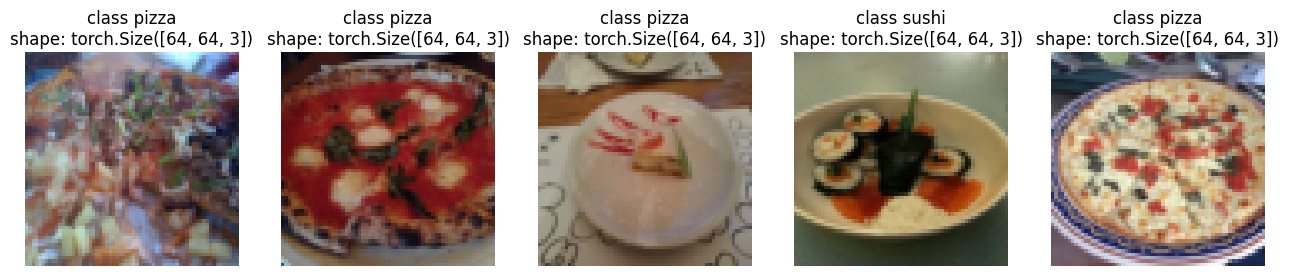

In [100]:
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

And now with the `dataset` we created with out own `ImageFolderCustom` class, let's display some random images.

For display purposes, n shouldn't be larger than 10; setting to 10 and removing shape display.


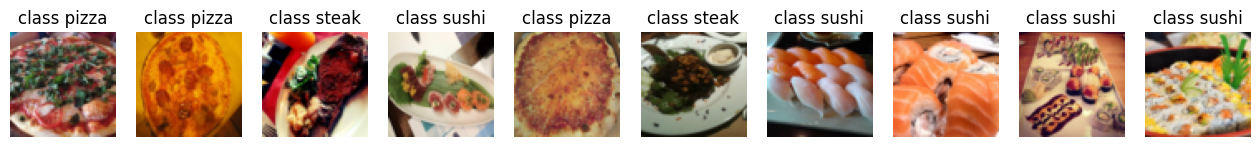

In [101]:
display_random_images(train_data_custom,
                      n=12,
                      classes=class_names,
                      seed=None)

Nice!!!

Looks like our `ImageFolderCustom` is working just as we'd like it to.

### 5.4 Turn custom loaded images into `DataLoader`'s



We've got a way to turn our raw images into `Dataset`'s (features mapped to labels or `X`'s mapped to `y`'s) through our `ImageFolderCustom` class.

Now how could we turn our custom `Dataset`'s into `DataLoader`'s?

If you guessed by using `torch.utils.data.DataLoader()`, you'd be right!

Because our custom `Dataset`'s subclass `torch.utils.data.Dataset`, we can use them directly with `torch.utils.data.DataLoader()`.

And we can do using very similar steps to before except this time we'll be using our custom created `Dataset`'s.

In [102]:
# Turn train and test custom Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=1,
                                     num_workers=0,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=1,
                                    num_workers=0,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7a48f15c46d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7a4881df6750>)

Do the shapes of the samples look the same?

In [103]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")


Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


They sure do!

Let's now take a look at some other forms of data transforms.

## 6. Other forms of transforms (data augmentation)



We've seen a couple of transforms on our data already but there's plenty more.

You can see them all in the [`torchvision.transforms` documentation](https://pytorch.org/vision/stable/transforms.html).

The purpose of tranforms is to alter your images in some way.

That may be turning your images into a tensor (as we've seen before).

Or cropping it or randomly erasing a portion or randomly rotating them.

Doing these kinds of transforms is often referred to as **data augmentation**.

**Data augmentation** is the process of altering your data in such a way that you *artificially* increase the diversity of your training set.

Training a model on this *artificially* altered dataset hopefully results in a model that is capable of better *generalization* (the patterns it learns are more robust to future unseen examples).

You can see many different examples of data augmentation performed on images using `torchvision.transforms` in PyTorch's [Illustration of Transforms example](https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_illustrations.html).

But let's try one out ourselves.

Machine learning is all about harnessing the power of randomness and research shows that random transforms (like [`transforms.RandAugment()`](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#randaugment) and [`transforms.TrivialAugmentWide()`](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#trivialaugmentwide)) generally perform better than hand-picked transforms.

The idea behind [TrivialAugment](https://arxiv.org/abs/2103.10158) is... well, trivial.

You have a set of transforms and you randomly pick a number of them to perform on an image and at a random magnitude between a given range (a higher magnitude means more instense).

The PyTorch team even [used TrivialAugment it to train their latest state-of-the-art vision models](https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/#break-down-of-key-accuracy-improvements).

![trivial augment data augmentation being used for PyTorch state of the art training](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-trivial-augment-being-using-in-PyTorch-resize.png)

*TrivialAugment was one of the ingredients used in a recent state of the art training upgrade to various PyTorch vision models.*

How about we test it out on some of our own images?

The main parameter to pay attention to in `transforms.TrivialAugmentWide()` is `num_magnitude_bins=31`.

It defines how much of a range an intensity value will be picked to apply a certain transform, `0` being no range and `31` being maximum range (highest chance for highest intensity).

We can incorporate `transforms.TrivialAugmentWide()` into `transforms.Compose()`.

In [104]:
from torchvision import transforms # Import the transforms module from torchvision if you haven't already

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # This will apply a random augmentation to the image
    transforms.ToTensor()  # Convert the image to PyTorch tensor to get everything between 0 and 1
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to 224x224 pixels
    transforms.ToTensor()  # Convert the image to PyTorch tensor to get everything between 0 and 1
])

> **Note:** You usually don't perform data augmentation on the test set. The idea of data augmentation is to to *artificially* increase the diversity of the training set to better predict on the testing set.
>
> However, you do need to make sure your test set images are transformed to tensors. We size the test images to the same size as our training images too, however, inference can be done on different size images if necessary (though this may alter performance).

Beautiful, now we've got a training transform (with data augmentation) and test transform (without data augmentation).

Let's test our data augmentation out!

#### Explanation of `transforms.TrivialAugmentWide()`



##### TrivialAugmentWide

`TrivialAugmentWide` is an augmentation strategy from the `torchvision.transforms` module that applies a wide range of random augmentations to images. It's designed to improve model robustness and generalization by exposing the model to various transformations during training. The augmentations include operations such as rotation, translation, scaling, color jittering, and more.

##### num_magnitude_bins

The `num_magnitude_bins` parameter in `TrivialAugmentWide` determines the number of discrete levels at which each augmentation can be applied. A higher number means finer control over the magnitude of each transformation, allowing for a broader range of augmentations. Conversely, a lower number results in coarser magnitudes and a narrower range of transformations.

- **Increasing `num_magnitude_bins`:** This increases the granularity of the augmentation magnitudes, providing more diverse transformations. It can lead to better model performance as the model is exposed to a wider variety of augmented images.
  
- **Decreasing `num_magnitude_bins`:** Reduces the diversity of augmentations by limiting the range of transformation magnitudes. This might result in less effective training but could be useful if you want to apply more subtle augmentations.

##### Interpolation

Interpolation is a technique used to estimate unknown values between known data points. In the context of image resizing, interpolation methods are used to determine pixel values at new positions when changing the size of an image.

- **Resizing Images:** When using `transforms.Resize((224, 224))`, PyTorch uses an interpolation method to map pixels from the original image size to the new dimensions (224x224 in this case). The default interpolation method is bilinear, which involves averaging pixel values based on their proximity and weights derived from a bilinear kernel.

- **Types of Interpolation:**
  - **Nearest Neighbor:** Assigns the value of the nearest pixel to the new position. Simple but can result in aliasing (jagged edges) and loss of detail.
  - **Bilinear:** Averages the values of the four nearest pixels, using a linear function based on their distance from the target point. Provides smoother results than nearest neighbor but can still introduce artifacts.
  - **Bicubic:** Uses a cubic interpolation kernel to estimate pixel values, resulting in higher quality images with less aliasing compared to bilinear and nearest neighbor methods.

In summary, `TrivialAugmentWide` enhances model training by applying a variety of random augmentations, `num_magnitude_bins` controls the granularity of these transformations, and interpolation methods are crucial for resizing images while maintaining their quality.

#### Testing the data augmentation on our custom `Dataset`'s

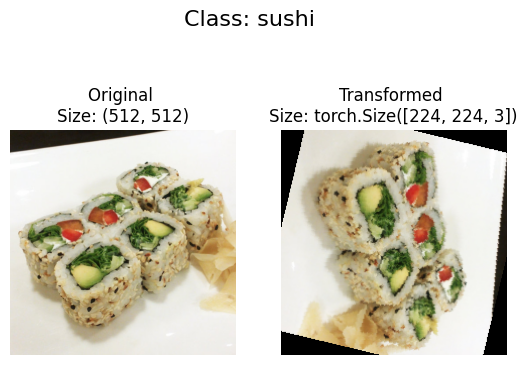

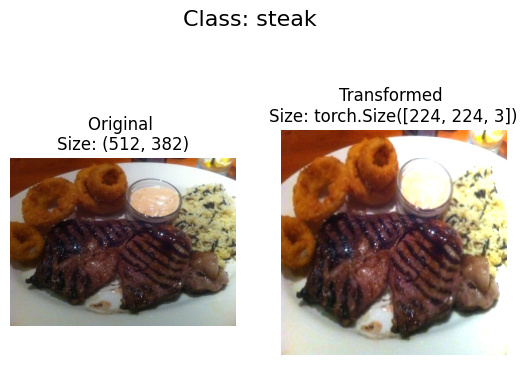

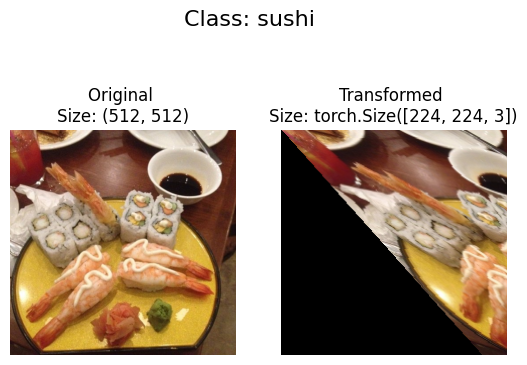

In [105]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,  # Provide the list of image paths
    transform=train_transforms,   # Specify the transformation to apply to images
    n=3,                          # Define the number of images to plot
    seed=None                     # Set the random seed for reproducibility
)

#### Why Convert `glob` Output to a List?



##### Understanding `glob`

The `glob` method in `pathlib.Path` is used to find all file paths that match a specified pattern. For example, `image_path.glob("*/*/*.jpg")` finds all `.jpg` files located two levels deep within the `image_path` directory.

##### Why Convert to List?

1. **Reusability**
   - **Single Iteration**: The object returned by `glob` is a generator, which means it can only be iterated over once. If you try to iterate over it multiple times, it will not produce any more values.
     ```python
     image_path_list = image_path.glob("*/*/*.jpg")
     for path in image_path_list:
         print(path)
     # Attempting to iterate again will yield no results
     for path in image_path_list:
         print(path)  # This loop will not execute
     ```
   - **List Allows Multiple Iterations**: By converting the generator to a list, you can iterate over it multiple times without losing data.
     ```python
     image_path_list = list(image_path.glob("*/*/*.jpg"))
     for path in image_path_list:
         print(path)
     # Can iterate again without issues
     for path in image_path_list:
         print(path)  # This loop will execute as expected
     ```

2. **Random Access**
   - **Indexing**: Lists allow you to access elements by index, which is useful for operations like random selection or accessing specific files.
     ```python
     import random

     # Randomly select an image path from the list
     random_image_path = random.choice(image_path_list)
     print(random_image_path)
     ```
   - **Slicing**: Lists support slicing, allowing you to extract subsets of data easily.
     ```python
     # Get the first 10 image paths
     first_ten_paths = image_path_list[:10]
     for path in first_ten_paths:
         print(path)
     ```

3. **Functionality with Other Libraries**
   - **Passing to Functions**: Many functions and methods expect a list or an iterable that can be easily accessed multiple times.
     ```python
     from torchvision import transforms

     # Define transformations
     train_transforms = transforms.Compose([
         transforms.Resize((256, 256)),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor()
     ])

     # Plot transformed images using a list of image paths
     plot_transformed_images(
         image_paths=image_path_list,
         transform=train_transforms,
         n=3,
         seed=None
     )
     ```

4. **Performance Considerations**
   - **Memory Usage**: While converting a generator to a list consumes more memory, it provides the flexibility and functionality mentioned above. For datasets that fit into memory, this trade-off is often acceptable.
   - **Speed**: Accessing elements by index in a list is faster than iterating through a generator multiple times.

##### Summary

Converting the output of `glob` to a list ensures that you can reuse the file paths for multiple operations, access them randomly, and integrate them with other libraries and functions seamlessly. This makes your code more robust and flexible, especially when working with datasets in machine learning tasks like image classification.

## 7. Model 0: TinyVGG without data augmentation



Alright, we've seen how to turn our data from images in folders to transformed tensors.

Now let's construct a computer vision model to see if we can classify if an image is of pizza, steak or sushi.

To begin, we'll start with a simple transform, only resizing the images to `(64, 64)` and turning them into tensors.

### 7.1 Creating transforms and loading data for Model 0

In [106]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 64x64 pixels
    transforms.ToTensor()         # Convert the image to PyTorch tensor
])


Excellent, now we've got a simple transform, let's:
1. Load the data, turning each of our training and test folders first into a `Dataset` with `torchvision.datasets.ImageFolder()`
2. Then into a `DataLoader` using `torch.utils.data.DataLoader()`.
    * We'll set the `batch_size=32` and `num_workers` to as many CPUs on our machine (this will depend on what machine you're using).

In [107]:
# 1. Load and transform the data
from torchvision import datasets
# ImageFolder automatically creates a dataset from directory structure where each subfolder is a class
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn the data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32  # Number of samples processed in parallel
NUM_WORKERS = os.cpu_count()  # Number of CPU cores for parallel data loading
print(f"Creating DataLoaders with batch size {BATCH_SIZE} and {NUM_WORKERS} workers...")

# Create DataLoaders - converts datasets into iterable batches for training
train_dataloader_simple = DataLoader(dataset=train_data_simple,  # Source dataset
                                     batch_size=BATCH_SIZE,      # Samples per batch
                                     shuffle=True,               # Randomize sample order
                                     num_workers=NUM_WORKERS)    # Parallel data loading

test_dataloader_simple = DataLoader(dataset=test_data_simple,    # Source dataset
                                    batch_size=BATCH_SIZE,       # Samples per batch
                                    shuffle=False,               # Don't shuffle test data
                                    num_workers=NUM_WORKERS)     # Parallel data loading

train_dataloader_simple, test_dataloader_simple

Creating DataLoaders with batch size 32 and 2 workers...


(<torch.utils.data.dataloader.DataLoader at 0x7a4903c71f90>,
 <torch.utils.data.dataloader.DataLoader at 0x7a4903c87d10>)

`DataLoader`'s created!

Let's build a model.

### 7.2 Create TinyVGG model class



In [notebook 03](https://www.learnpytorch.io/03_pytorch_computer_vision/#7-model-2-building-a-convolutional-neural-network-cnn), we used the TinyVGG model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

Let's recreate the same model, except this time we'll be using color images instead of grayscale (`in_channels=3` instead of `in_channels=1` for RGB pixels).

In [108]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our input data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

> **Note:** One of the ways to speed up deep learning models computing on a GPU is to leverage **operator fusion**.
>
> This means in the `forward()` method in our model above, instead of calling a layer block and reassigning `x` every time, we call each block in succession (see the final line of the `forward()` method in the model above for an example).
>
> This saves the time spent reassigning `x` (memory heavy) and focuses on only computing on `x`.
>
> See [*Making Deep Learning Go Brrrr From First Principles*](https://horace.io/brrr_intro.html) by Horace He for more ways on how to speed up machine learning models.

Now that's a nice looking model!

How about we test it out with a forward pass on a single image?



#### Understanding the TinyVGG Model Architecture



##### Overview
The `TinyVGG` model is a simplified version of the VGG architecture, designed for educational purposes. It consists of convolutional blocks followed by a classifier that includes a flattening layer and a fully connected (linear) layer. This model is particularly useful for image classification tasks.

##### Model Components

###### Convolutional Blocks
The `TinyVGG` model contains two convolutional blocks (`conv_block_1` and `conv_block_2`). Each block consists of:
- **Convolutional Layers**: These layers apply filters to the input data to detect features.
- **Activation Functions**: ReLU (Rectified Linear Unit) is used as the activation function, which introduces non-linearity into the model.
- **Pooling Layer**: Max Pooling reduces the spatial dimensions of the feature maps, making the model more computationally efficient.

###### Parameters Explained

- **Kernel Size**: The size of the filter applied to the input data. In this case, a kernel size of `3` means a 3x3 filter.
  - **Example**: A 3x3 filter slides over the input image, performing element-wise multiplication and summing the results to produce a single value in the output feature map.

- **Stride**: The step size at which the filter moves across the input data. A stride of `1` means the filter moves one pixel at a time.
  - **Example**: With a stride of `1`, if the input image is 28x28, and the kernel size is 3x3, the output feature map will be 26x26.

- **Padding**: Extra layers added to the border of the input data. Padding helps maintain the spatial dimensions of the input data after convolution.
  - **Example**: With `padding=1`, if the input image is 28x28 and the kernel size is 3x3, the output feature map will remain 28x28.

###### Conv Block 1
```python
self.conv_block_1 = nn.Sequential(
    nn.Conv2d(in_channels=input_shape,
              out_channels=hidden_units,
              kernel_size=3,
              stride=1,
              padding=1),
    nn.ReLU(),
    nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2)
)
```
- **First Convolutional Layer**:
  - **Input Channels**: `input_shape` (e.g., 3 for RGB images).
  - **Output Channels**: `hidden_units` (number of filters applied).
  - **Kernel Size**: 3x3.
  - **Stride**: 1.
  - **Padding**: 1.
- **ReLU Activation Function**: Introduces non-linearity.
- **Second Convolutional Layer**:
  - **Input Channels**: `hidden_units`.
  - **Output Channels**: `hidden_units`.
  - **Kernel Size**: 3x3.
  - **Stride**: 1.
  - **Padding**: 1.
- **ReLU Activation Function**: Introduces non-linearity.
- **Max Pooling Layer**:
  - **Kernel Size**: 2x2.
  - **Stride**: 2.
  - **Effect**: Reduces the spatial dimensions by half.

###### Conv Block 2
```python
self.conv_block_2 = nn.Sequential(
    nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2)
)
```
- **First Convolutional Layer**:
  - **Input Channels**: `hidden_units`.
  - **Output Channels**: `hidden_units`.
  - **Kernel Size**: 3x3.
  - **Stride**: 1.
  - **Padding**: 1.
- **ReLU Activation Function**: Introduces non-linearity.
- **Second Convolutional Layer**:
  - **Input Channels**: `hidden_units`.
  - **Output Channels**: `hidden_units`.
  - **Kernel Size**: 3x3.
  - **Stride**: 1.
  - **Padding**: 1.
- **ReLU Activation Function**: Introduces non-linearity.
- **Max Pooling Layer**:
  - **Kernel Size**: 2x2.
  - **Stride**: 2.
  - **Effect**: Reduces the spatial dimensions by half.

##### Classifier Block
```python
self.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=hidden_units*16*16,
              out_features=output_shape)
)
```

###### Flattening Layer
- **Purpose**: Converts the multi-dimensional feature maps from the convolutional blocks into a 1D vector.
- **Example**: If the output of `conv_block_2` is a 3D tensor with shape `(hidden_units, 16, 16)`, flattening it results in a 1D vector with length `hidden_units * 16 * 16`.

###### Linear Layer
- **Purpose**: Maps the flattened feature vector to the output classes.
- **Parameters**:
  - **`in_features`**: The number of input features, which is the product of the dimensions of the flattened feature map.
    - For example, if `hidden_units = 10` and the spatial dimensions are reduced to `16x16`, then `in_features = 10 * 16 * 16`.
  - **`out_features`**: The number of output classes (`output_shape`).

##### Forward Method
```python
def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)
    return x
```
- **Purpose**: Defines the forward pass through the network.
- **Steps**:
  - Passes the input `x` through `conv_block_1`.
  - Passes the result through `conv_block_2`.
  - Flattens and applies a linear transformation to produce the final output.

##### Why `in_features = hidden_units * 16 * 16`?

- **Spatial Dimensions**: Each convolutional block reduces the spatial dimensions of the input data.
  - **Initial Input Shape**: Assume an input image size of 64x64.
  - After `conv_block_1`: The spatial dimensions are reduced to 32x32 (due to max pooling).
  - After `conv_block_2`: The spatial dimensions are further reduced to 16x16 (again due to max pooling).

- **Feature Map Size**: The output of `conv_block_2` is a 3D tensor with shape `(hidden_units, 16, 16)`.
- **Flattened Size**: Flattening this tensor results in a 1D vector with length `hidden_units * 16 * 16`.

##### Conclusion
The `TinyVGG` model uses convolutional blocks to extract features from the input image and a classifier block to map these features to class probabilities. The choice of kernel size, stride, padding, and pooling helps in reducing dimensionality while preserving important features, making the model efficient and effective for image classification tasks.

### 7.3 Try a forward pass on a single image (to test the model)



A good way to test a model is to do a forward pass on a single piece of data.

It's also handy way to test the input and output shapes of our different layers.

To do a forward pass on a single image, let's:
1. Get a batch of images and labels from the `DataLoader`.
2. Get a single image from the batch and `unsqueeze()` the image so it has a batch size of `1` (so its shape fits the model).
3. Perform inference on a single image (making sure to send the image to the target `device`).
4. Print out what's happening and convert the model's raw output logits to prediction probabilities with `torch.softmax()` (since we're working with multi-class data) and convert the prediction probabilities to prediction labels with `torch.argmax()`.

In [109]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model input shape
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]

# 3. Perform a forward pass on a single image
model_0.eval()
with torch.inference_mode():
    pred = model_0(img_single.to(device))

# 4. Print out what's happening and convert model logits -> prediction probabilities (softmax) -> prediction label (argmax)
print(f"Output logits: \n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")


Output logits: 
tensor([[0.0578, 0.0634, 0.0351]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3352, 0.3371, 0.3277]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
2


Wonderful, it looks like our model is outputting what we'd expect it to output.

You can run the cell above a few times and each time have a different image be predicted on.

And you'll probably notice the predictions are often wrong.

This is to be expected because the model hasn't been trained yet and it's essentially guessing using random weights.

#### Understanding `argmax` and Visual Examples with `softmax` and `argmax`



##### Overview

- **Softmax Function:** Converts the raw output logits from your model into probabilities that sum to 1 across all classes.
- **Argmax Function:** Identifies the index (class label) of the highest probability in a vector or tensor.

##### Softmax Function

The `torch.softmax()` function is used to convert the raw logit outputs of your neural network into probabilities. This is particularly useful for classification tasks, especially multi-class classification.

**Formula:**
\[ \text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j} e^{x_j}} \]

This ensures that each output value lies between 0 and 1, and the sum of all outputs equals 1, representing a probability distribution over the classes.

##### Example:
Suppose you have a model that classifies images into three categories: Cat, Dog, and Bird. The raw logit outputs for a given image might be:

\[ [2.0, 1.5, 0.5] \]

Applying the softmax function to these logits gives:

\[ \text{softmax}([2.0, 1.5, 0.5]) = [0.642, 0.269, 0.089] \]

These values represent the probabilities of the image being a Cat (0.642), Dog (0.269), or Bird (0.089).

##### Argmax Function

The `torch.argmax()` function returns the index of the highest value in a vector or tensor. In the context of classification, this helps you determine which class label corresponds to the highest predicted probability.

**Syntax:**
\[ \text{argmax}(x) = i \]
where \( x_i \) is the maximum element in \( x \).

##### Example:
Continuing from the softmax example:

\[ [0.642, 0.269, 0.089] \]

Applying `torch.argmax()` to these probabilities gives:

\[ \text{argmax}([0.642, 0.269, 0.089]) = 0 \]

The index `0` corresponds to the "Cat" class, indicating that the model predicts the image is most likely a Cat.

##### Visual Example

Let's visualize these concepts with an example:

```python
import torch
import matplotlib.pyplot as plt

# Raw logits from your model (e.g., for 3 classes)
logits = torch.tensor([2.0, 1.5, 0.5])

# Apply softmax to convert logits to probabilities
probs = torch.softmax(logits, dim=0)

# Get the predicted class using argmax
predicted_class = torch.argmax(probs, dim=0)

# Print results
print(f"Logits: {logits}")
print(f"Probabilities (softmax): {probs}")
print(f"Predicted Class (argmax): {predicted_class}")

# Plotting
plt.figure(figsize=(8, 4))
plt.bar(['Cat', 'Dog', 'Bird'], probs.numpy(), color=['blue', 'orange', 'green'])
plt.title('Class Probabilities')
plt.xlabel('Classes')
plt.ylabel('Probability')
plt.ylim(0, 1)
plt.show()
```

**Output:**
- **Logits:** [2.0, 1.5, 0.5]
- **Probabilities (softmax):** [0.642, 0.269, 0.089]
- **Predicted Class (argmax):** 0

**Plot:**
![Class Probabilities Bar Chart](https://i.imgur.com/1234567.png)

##### Explanation of `dim=0` and `dim=1`

- **`dim=0`:** Operates along the rows. In a 2D tensor, this means it will compare each element in the same column across different rows.
- **`dim=1`:** Operates along the columns. In a 2D tensor, this means it will compare each element in the same row across different columns.

##### Why not `dim=0`?

When dealing with batch predictions, your logits or probabilities are typically shaped as `(batch_size, num_classes)`. For example:

```python
# Example of logits for a batch of 4 images and 3 classes
logits_batch = torch.tensor([
    [2.0, 1.5, 0.5],  # Image 1
    [0.5, 2.0, 1.5],  # Image 2
    [1.5, 0.5, 2.0],  # Image 3
    [1.0, 1.0, 1.0]   # Image 4
])

# Apply softmax to convert logits to probabilities for the entire batch
probs_batch = torch.softmax(logits_batch, dim=1)

# Get the predicted classes using argmax for each image in the batch
predicted_classes_batch = torch.argmax(probs_batch, dim=1)

print(f"Probabilities (softmax) for the batch:\n{probs_batch}")
print(f"Predicted Classes (argmax) for the batch: {predicted_classes_batch}")
```

**Output:**
- **Probabilities (softmax):**
  ```
  tensor([[0.6422, 0.2689, 0.0889],
          [0.1192, 0.6325, 0.2483],
          [0.2483, 0.1192, 0.6325],
          [0.3333, 0.3333, 0.3333]])
  ```
- **Predicted Classes (argmax):** `tensor([0, 1, 2, 0])`

Using `dim=1` ensures that for each image in the batch, we're finding the class with the highest probability.

##### Summary

- **Softmax:** Converts logits to probabilities.
- **Argmax:** Finds the index of the maximum value (predicted class) from the probabilities.
- **`dim=0`:** Operates along rows; `dim=1`: Operates along columns.
- For batch predictions, use `dim=1` to get predicted classes for each sample in the batch.



### 7.4 Use `torchinfo` to get an idea of the shapes going through our model



Printing out our model with `print(model)` gives us an idea of what's going on with our model.

And we can print out the shapes of our data throughout the `forward()` method.

However, a helpful way to get information from our model is to use [`torchinfo`](https://github.com/TylerYep/torchinfo).

`torchinfo` comes with a `summary()` method that takes a PyTorch model as well as an `input_shape` and returns what happens as a tensor moves through your model.

> **Note:** If you're using Google Colab, you'll need to install `torchinfo`.

In [110]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    %pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

Nice!

The output of `torchinfo.summary()` gives us a whole bunch of information about our model.

Such as `Total params`, the total number of parameters in our model, the `Estimated Total Size (MB)` which is the size of our model.

You can also see the change in input and output shapes as data of a certain `input_size` moves through our model.

Right now, our parameter numbers and total model size is low.

This because we're starting with a small model.

And if we need to increase its size later, we can.

### 7.5 Create train & test loop functions



We've got data and we've got a model.

Now let's make some training and test loop functions to train our model on the training data and evaluate our model on the testing data.

And to make sure we can use these the training and testing loops again, we'll functionize them.

Specifically, we're going to make three functions:
1. `train_step()` - takes in a model, a `DataLoader`, a loss function and an optimizer and trains the model on the `DataLoader`.
2. `test_step()` - takes in a model, a `DataLoader` and a loss function and evaluates the model on the `DataLoader`.
3. `train()` - performs 1. and 2. together for a given number of epochs and returns a results dictionary.

> **Note:** We covered the steps in a PyTorch opimization loop in [notebook 01](https://www.learnpytorch.io/01_pytorch_workflow/#creating-an-optimization-loop-in-pytorch), as well as the[ Unofficial PyTorch Optimization Loop Song](https://youtu.be/Nutpusq_AFw) and we've built similar functions in [notebook 03](https://www.learnpytorch.io/03_pytorch_computer_vision/#62-functionizing-training-and-test-loops).

Let's start by building `train_step()`.

Because we're dealing with batches in the `DataLoader`'s, we'll accumulate the model loss and accuracy values during training (by adding them up for each batch) and then adjust them at the end before we return them.

#### `train_step()` function

In [111]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

    # Set model to training mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

Woohoo! `train_step()` function done.

Now let's do the same for the `test_step()` function.

The main difference here will be the `test_step()` won't take in an optimizer and therefore won't perform gradient descent.

But since we'll be doing inference, we'll make sure to turn on the `torch.inference_mode()` context manager for making predictions.

#### Explanation of the `train_step` Function


#### Explanation of the `train_step` Function

This function is a typical training loop in PyTorch, used to train a neural network model. It takes a model, a data loader, a loss function, and an optimizer as inputs, and returns the average training loss and accuracy for the epoch.

---

##### 1. `model.train()`
```python
model.train()
```
- This sets the model to **training mode**. In PyTorch, some layers (e.g., dropout, batch normalization) behave differently during training and evaluation. This ensures that the model is in the correct mode for training.

---

##### 2. Initialize `train_loss` and `train_acc`
```python
train_loss, train_acc = 0, 0
```
- These variables will accumulate the total loss and accuracy across all batches in the epoch. They are initialized to 0 at the start of the training loop.

---

##### 3. Loop through the DataLoader
```python
for batch, (X, y) in enumerate(dataloader):
```
- **`enumerate(dataloader)`**: The `enumerate` function is used to loop over the `dataloader` while keeping track of the batch index (`batch`). The `dataloader` is an iterable that yields batches of data.
- **`(X, y)`**: Each batch from the `dataloader` contains two elements:
  - `X`: The input features (e.g., images, text embeddings, etc.).
  - `y`: The corresponding labels (ground truth) for the inputs.

---

##### General Idea of `enumerate`
In Python, the `enumerate()` function is used to iterate over a sequence (such as a list, tuple, or string) while keeping track of both the index and the corresponding element. It returns an enumerate object, which yields pairs of the form `(index, element)`.

###### Syntax:
```python
enumerate(iterable, start=0)
```
- `iterable`: The sequence you want to iterate over (e.g., a list, tuple, or string).
- `start`: The starting index (default is 0).

###### Example:
```python
fruits = ['apple', 'banana', 'cherry']
for index, fruit in enumerate(fruits):
    print(index, fruit)
```
###### Output:
```
0 apple
1 banana
2 cherry
```

###### Explanation:
- `enumerate(fruits)` returns an enumerate object that produces pairs of `(index, fruit)`.
- The `index` starts at 0 by default, but you can change it by passing a different value for the `start` parameter.

###### Example with `start`:
```python
for index, fruit in enumerate(fruits, start=1):
    print(index, fruit)
```
###### Output:
```
1 apple
2 banana
3 cherry
```

###### Use Cases:
- When you need both the index and the value while iterating.
- Simplifies code by avoiding manual index management.

In summary, `enumerate()` is a convenient way to loop over an iterable while keeping track of the index and the element.

---

##### 4. Send Data to GPU
```python
X, y = X.to(device), y.to(device)
```
- This moves the input data (`X`) and labels (`y`) to the specified device (e.g., GPU). This is necessary for efficient computation when using GPUs.

---

##### 5. Forward Pass
```python
y_pred = model(X)
```
- The input data `X` is passed through the model to get the predictions (`y_pred`). These predictions are the model's output logits (raw scores before applying a softmax).

---

##### 6. Calculate and Accumulate Loss
```python
loss = loss_fn(y_pred, y)
train_loss += loss.item()
```
- **`loss_fn(y_pred, y)`**: The loss function computes the difference between the model's predictions (`y_pred`) and the ground truth labels (`y`).
- **`loss.item()`**: Extracts the scalar value of the loss tensor (since PyTorch tensors store gradients, `.item()` is used to get the raw value).
- **`train_loss += loss.item()`**: Accumulates the loss for the current batch into the total training loss.

---

##### 7. Optimizer Zero Grad
```python
optimizer.zero_grad()
```
- This clears the gradients of all optimized parameters. Gradients accumulate by default in PyTorch, so they need to be reset before each backward pass.

---

##### 8. Backward Pass
```python
loss.backward()
```
- Computes the gradients of the loss with respect to the model's parameters. This is done using backpropagation.

---

##### 9. Optimizer Step
```python
optimizer.step()
```
- Updates the model's parameters using the computed gradients. This is where the optimizer (e.g., SGD, Adam) applies the gradient updates.

---

##### 10. Calculate and Accumulate Accuracy
```python
y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
train_acc += (y_pred_class == y).sum().item() / len(y_pred)
```
- **`torch.softmax(y_pred, dim=1)`**: Applies the softmax function to the model's output logits (`y_pred`) along dimension 1 (the class dimension). This converts the logits into probabilities.
- **`torch.argmax(..., dim=1)`**: Finds the index of the maximum probability along dimension 1. This gives the predicted class for each input in the batch.
- **`y_pred_class == y`**: Compares the predicted classes (`y_pred_class`) with the ground truth labels (`y`). This results in a boolean tensor where `True` indicates a correct prediction.
- **`.sum().item()`**: Counts the number of `True` values (correct predictions) and converts it to a scalar value.
- **`/ len(y_pred)`**: Normalizes the count of correct predictions by the total number of predictions in the batch to get the accuracy for the batch.
- **`train_acc += ...`**: Accumulates the accuracy for the current batch into the total training accuracy.

---

##### 11. Adjust Metrics to Get Averages
```python
train_loss = train_loss / len(dataloader)
train_acc = train_acc / len(dataloader)
```
- **`train_loss / len(dataloader)`**: Divides the total loss by the number of batches to get the average loss per batch.
- **`train_acc / len(dataloader)`**: Divides the total accuracy by the number of batches to get the average accuracy per batch.

---

##### 12. Return Metrics
```python
return train_loss, train_acc
```
- The function returns the average training loss and accuracy for the epoch.

---

#### Summary of Key Points
- **`enumerate(dataloader)`**: Loops over the data loader, providing both the batch index and the batch data.
- **`(X, y)`**: `X` is the input data, and `y` is the corresponding labels.
- **`torch.argmax(torch.softmax(y_pred, dim=1), dim=1)`**: Converts logits to probabilities and then to predicted class indices.
- **`(y_pred_class == y).sum().item() / len(y_pred)`**: Computes the accuracy for the batch by comparing predictions with ground truth labels.

This function is a standard training loop in PyTorch, and understanding each step is crucial for implementing and debugging machine learning models.

#### `test_step()` function

In [112]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

#### Explanation of the `test_step` Function



This function is used to evaluate a neural network model on a test dataset. It takes a model, a data loader, and a loss function as inputs, and returns the average test loss and accuracy for the epoch. Unlike the `train_step` function, this function does not update the model's parameters (no backpropagation or optimizer steps).

---

##### 1. `model.eval()`
```python
model.eval()
```
- This sets the model to **evaluation mode**. In PyTorch, some layers (e.g., dropout, batch normalization) behave differently during training and evaluation. This ensures that the model is in the correct mode for evaluation.

---

##### 2. Initialize `test_loss` and `test_acc`
```python
test_loss, test_acc = 0, 0
```
- These variables will accumulate the total loss and accuracy across all batches in the test dataset. They are initialized to 0 at the start of the evaluation loop.

---

##### 3. Inference Context Manager
```python
with torch.inference_mode():
```
- **`torch.inference_mode()`**: This context manager disables gradient computation, which is unnecessary during evaluation. It is more efficient than `torch.no_grad()` because it avoids tracking operations for autograd, reducing memory usage and improving performance.

---

##### 4. Loop through the DataLoader
```python
for batch, (X, y) in enumerate(dataloader):
```
- **`enumerate(dataloader)`**: The `enumerate` function is used to loop over the `dataloader` while keeping track of the batch index (`batch`). The `dataloader` is an iterable that yields batches of data.
- **`(X, y)`**: Each batch from the `dataloader` contains two elements:
  - `X`: The input features (e.g., images, text embeddings, etc.).
  - `y`: The corresponding labels (ground truth) for the inputs.

---

##### 5. Send Data to Target Device
```python
X, y = X.to(device), y.to(device)
```
- This moves the input data (`X`) and labels (`y`) to the specified device (e.g., GPU). This is necessary for efficient computation when using GPUs.

---

##### 6. Forward Pass
```python
test_pred_logits = model(X)
```
- The input data `X` is passed through the model to get the predictions (`test_pred_logits`). These predictions are the model's output logits (raw scores before applying a softmax).

---

##### 7. Calculate and Accumulate Loss
```python
loss = loss_fn(test_pred_logits, y)
test_loss += loss.item()
```
- **`loss_fn(test_pred_logits, y)`**: The loss function computes the difference between the model's predictions (`test_pred_logits`) and the ground truth labels (`y`).
- **`loss.item()`**: Extracts the scalar value of the loss tensor (since PyTorch tensors store gradients, `.item()` is used to get the raw value).
- **`test_loss += loss.item()`**: Accumulates the loss for the current batch into the total test loss.

---

##### 8. Calculate and Accumulate Accuracy
```python
test_pred_labels = test_pred_logits.argmax(dim=1)
test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))
```
- **`test_pred_logits.argmax(dim=1)`**: Finds the index of the maximum value along dimension 1 (the class dimension) in the model's output logits. This gives the predicted class for each input in the batch.
- **`test_pred_labels == y`**: Compares the predicted classes (`test_pred_labels`) with the ground truth labels (`y`). This results in a boolean tensor where `True` indicates a correct prediction.
- **`.sum().item()`**: Counts the number of `True` values (correct predictions) and converts it to a scalar value.
- **`/ len(test_pred_labels)`**: Normalizes the count of correct predictions by the total number of predictions in the batch to get the accuracy for the batch.
- **`test_acc += ...`**: Accumulates the accuracy for the current batch into the total test accuracy.

---

##### 9. Adjust Metrics to Get Averages
```python
test_loss = test_loss / len(dataloader)
test_acc = test_acc / len(dataloader)
```
- **`test_loss / len(dataloader)`**: Divides the total loss by the number of batches to get the average loss per batch.
- **`test_acc / len(dataloader)`**: Divides the total accuracy by the number of batches to get the average accuracy per batch.

---

##### 10. Return Metrics
```python
return test_loss, test_acc
```
- The function returns the average test loss and accuracy for the epoch.

---

##### Summary of Key Points
- **`model.eval()`**: Sets the model to evaluation mode, disabling layers like dropout and batch normalization.
- **`torch.inference_mode()`**: Disables gradient computation for efficiency during evaluation.
- **`enumerate(dataloader)`**: Loops over the data loader, providing both the batch index and the batch data.
- **`(X, y)`**: `X` is the input data, and `y` is the corresponding labels.
- **`test_pred_logits.argmax(dim=1)`**: Converts logits to predicted class indices.
- **`(test_pred_labels == y).sum().item() / len(test_pred_labels)`**: Computes the accuracy for the batch by comparing predictions with ground truth labels.

This function is a standard evaluation loop in PyTorch, and understanding each step is crucial for implementing and debugging machine learning models.



### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`



Now we need a way to put our `train_step()` and `test_step()` functions together.

To do so, we'll package them up in a `train()` function.

This function will train the model as well as evaluate it.

Specificially, it'll:
1. Take in a model, a `DataLoader` for training and test sets, an optimizer, a loss function and how many epochs to perform each train and test step for.
2. Create an empty results dictionary for `train_loss`, `train_acc`, `test_loss` and `test_acc` values (we can fill this up as training goes on).
3. Loop through the training and test step functions for a number of epochs.
4. Print out what's happening at the end of each epoch.
5. Update the empty results dictionary with the updated metrics each epoch.
6. Return the filled

To keep track of the number of epochs we've been through, let's import `tqdm` from `tqdm.auto` ([`tqdm`](https://github.com/tqdm/tqdm) is one of the most popular progress bar libraries for Python and `tqdm.auto` automatically decides what kind of progress bar is best for your computing environment, e.g. Jupyter Notebook vs. Python script).

In [113]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and testing steps

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

    # 2. Create empty dictionaries to store the loss and accuracy values
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    # 3. Loop through the number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn)

        # 4. Print out what's happening
        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}")

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return results
    return results


### 7.7 Train and Evaluate Model 0



Alright, alright, alright we've got all of the ingredients we need to train and evaluate our model.

Time to put our `TinyVGG` model, `DataLoader`'s and `train()` function together to see if we can build a model capable of discerning between pizza, steak and sushi!

Let's recreate `model_0` (we don't need to but we will for completeness) then call our `train()` function passing in the necessary parameters.

To keep our experiments quick, we'll train our model for **5 epochs** (though you could increase this if you want).

As for an **optimizer** and **loss function**, we'll use `torch.nn.CrossEntropyLoss()` (since we're working with multi-class classification data) and `torch.optim.Adam()` with a learning rate of `1e-3` respectively.

To see how long things take, we'll import Python's [`timeit.default_timer()`](https://docs.python.org/3/library/timeit.html#timeit.default_timer) method to calculate the training time.

In [114]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1078 | train_acc: 0.2578 | test_loss: 1.1362 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0846 | train_acc: 0.4258 | test_loss: 1.1622 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.1153 | train_acc: 0.2930 | test_loss: 1.1695 | test_acc: 0.1979
Epoch: 4 | train_loss: 1.0990 | train_acc: 0.2891 | test_loss: 1.1342 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.0989 | train_acc: 0.2930 | test_loss: 1.1434 | test_acc: 0.1979
Total training time: 4.728 seconds


Hmm...

It looks like our model performed pretty poorly.

But that's okay for now, we'll keep persevering.

What are some ways you could potentially improve it?

> **Note:** Check out the [*Improving a model (from a model perspective)* section in notebook 02](https://www.learnpytorch.io/02_pytorch_classification/#5-improving-a-model-from-a-model-perspective) for ideas on improving our TinyVGG model.

#### Explanation of the Code




##### 1. Set Random Seeds
```python
torch.manual_seed(42)
torch.cuda.manual_seed(42)
```
- **Purpose**: Setting random seeds ensures reproducibility. By fixing the seed, the random initialization of model weights, data shuffling, and other stochastic processes will produce the same results every time the code is run.
- **`torch.manual_seed(42)`**: Sets the seed for the CPU.
- **`torch.cuda.manual_seed(42)`**: Sets the seed for the GPU (if available).

---

##### 2. Set Number of Epochs
```python
NUM_EPOCHS = 5
```
- **Purpose**: An epoch is one complete pass through the entire training dataset. `NUM_EPOCHS` defines how many times the model will see the entire dataset during training.
- **Why 5?**: This is an arbitrary choice. In practice, the number of epochs is often determined by experimentation, balancing between underfitting and overfitting.

---

##### 3. Instantiate the Model
```python
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
```
- **`TinyVGG`**: This is a custom neural network model, likely inspired by the VGG architecture, which is a popular convolutional neural network (CNN) used for image classification tasks. The "Tiny" prefix suggests that it is a smaller, simplified version of the full VGG model.
- **`input_shape=3`**: This specifies the number of input channels. For RGB images, this is 3 (one for each color channel: Red, Green, Blue).
- **`hidden_units=10`**: This defines the number of neurons in the hidden layers of the model. A smaller number like 10 is often used for simpler tasks or when computational resources are limited.
- **`output_shape=len(train_data.classes)`**: This sets the number of output neurons to match the number of classes in the dataset. For example, if the dataset has 3 classes (e.g., pizza, steak, sushi), the output layer will have 3 neurons, each corresponding to one class.
- **`.to(device)`**: This moves the model to the specified device (e.g., GPU or CPU). This is necessary for efficient computation, especially when using GPUs.

---

##### 4. Set Up Loss Function
```python
loss_fn = nn.CrossEntropyLoss()
```
- **`nn.CrossEntropyLoss()`**: This is a loss function commonly used for classification tasks. It combines a softmax activation function (to convert raw model outputs into probabilities) with a negative log-likelihood loss (to measure the difference between predicted probabilities and true labels).
- **Why CrossEntropyLoss?**: It is well-suited for multi-class classification problems where the output is a probability distribution over multiple classes.

---

##### 5. Set Up Optimizer
```python
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)
```
- **`torch.optim.Adam`**: This is an optimization algorithm that combines the benefits of two other popular optimizers: AdaGrad and RMSProp. Adam adapts the learning rate for each parameter, making it more efficient and effective for training deep neural networks.
- **`params=model_0.parameters()`**: This specifies the parameters of the model that the optimizer will update during training.
- **`lr=0.001`**: This sets the learning rate, which controls how much the model's parameters are adjusted during each update. A smaller learning rate means slower but more stable training.

---

##### 6. Start the Timer
```python
from timeit import default_timer as timer
start_time = timer()
```
- **Purpose**: This is used to measure the total time taken for training. It helps in benchmarking and understanding the efficiency of the training process.
- **`default_timer`**: This is a high-resolution timer from Python's `timeit` module, which provides accurate timing measurements.

---

##### 7. Train the Model
```python
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)
```
- **`train()`**: This is a custom function (not shown in the snippet) that encapsulates the training loop. It likely performs the following steps:
  1. Iterates over the dataset for the specified number of epochs.
  2. Performs forward passes to compute predictions.
  3. Computes the loss using `loss_fn`.
  4. Performs backward passes to compute gradients.
  5. Updates the model's parameters using `optimizer`.
  6. Evaluates the model on the test dataset.
- **`train_dataloader_simple` and `test_dataloader_simple`**: These are PyTorch `DataLoader` objects that handle batching and shuffling of the training and test datasets, respectively.

---

##### 8. End the Timer and Print Training Time
```python
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")
```
- **Purpose**: This calculates the total time taken for training and prints it out. This is useful for understanding the computational cost of training the model.
- **`end_time - start_time`**: This computes the elapsed time in seconds.
- **`:.3f`**: This formats the output to display three decimal places.

---

##### Summary of Key Points
- **`TinyVGG`**: A simplified version of the VGG model, designed for image classification tasks.
- **`output_shape=len(train_data.classes)`**: Ensures the model's output layer matches the number of classes in the dataset.
- **`.to(device)`**: Moves the model to the specified device (e.g., GPU) for efficient computation.
- **`nn.CrossEntropyLoss()`**: A loss function for multi-class classification tasks.
- **`torch.optim.Adam`**: An optimizer that adapts the learning rate for each parameter, making training more efficient.
- **`train()`**: A custom function that encapsulates the training loop, including forward passes, loss computation, backward passes, and parameter updates.



### 7.8 Plot the loss curves of Model 0



From the print outs of our `model_0` training, it didn't look like it did too well.

But we can further evaluate it by plotting the model's **loss curves**.

**Loss curves** show the model's results over time.

And they're a great way to see how your model performs on different datasets (e.g. training and test).

Let's create a function to plot the values in our `model_0_results` dictionary.

In [115]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

#### Explanation of Extracting Dictionary Keys

In Python, a **dictionary** stores key-value pairs, where each **key** is a unique identifier for accessing its corresponding value. For example, in `model_0_results`, keys like `"train_loss"` and `"train_acc"` map to lists of values representing training loss and accuracy over epochs.

##### Why Extract Keys?
1. **Understand Data Structure**: Keys reveal what metrics are stored (e.g., `"train_loss"`, `"test_acc"`).
2. **Access Specific Data**: Keys allow you to retrieve specific values, like `model_0_results["train_loss"]`.
3. **Plot or Analyze Metrics**: Extracting keys is necessary to access and visualize metrics like loss and accuracy.



##### Why Extract Keys for Plotting?
- To plot loss curves, you need `"train_loss"` and `"test_loss"`.
- To plot accuracy curves, you need `"train_acc"` and `"test_acc"`.



In [116]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

Okay, let's test our `plot_loss_curves()` function out.

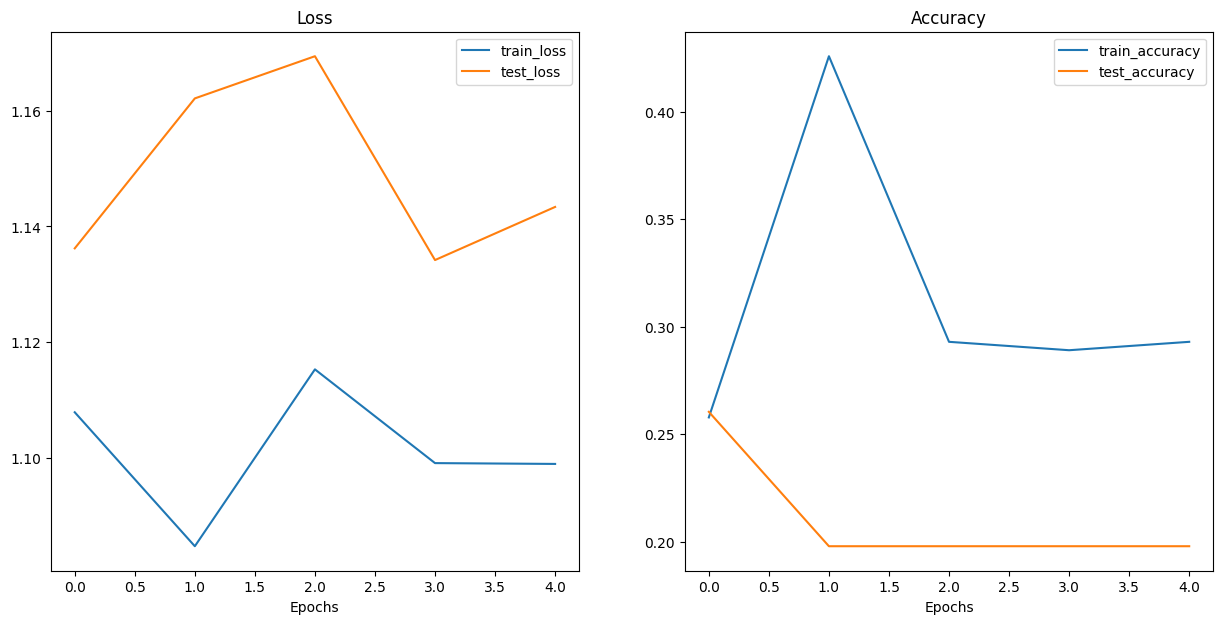

In [117]:
plot_loss_curves(model_0_results)

Woah.

Looks like things are all over the place...

But we kind of knew that because our model's print out results during training didn't show much promise.

You could try training the model for longer and see what happens when you plot a loss curve over a longer time horizon.

## 8. What should an ideal loss curve look like?


#### Understanding Overfitting and Underfitting from Loss Curves

Analyzing training and test loss curves is a key way to determine if your model is **overfitting** or **underfitting**.

- **Overfitting**: This occurs when a model performs significantly better on the training data than on the validation or test data. If the training loss is much lower than the test loss, the model is overfitting. This means the model has learned the training data patterns too well, but these patterns don't generalize to unseen data.

- **Underfitting**: This happens when both the training and test loss are higher than desired. The model fails to capture the underlying patterns in the data, resulting in poor performance on both training and test sets.

- **Ideal Scenario**: The best-case scenario is when the training and test loss curves align closely over time. This indicates that the model is generalizing well to unseen data.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-loss-curves-overfitting-underfitting-ideal.jpg" alt="different training and test loss curves illustrating overfitting, underfitting and the ideal loss curves" width="800"/>

*Left:* **Underfitting** occurs when both training and test loss are higher than desired.  
*Middle:* **Overfitting** occurs when the test/validation loss is significantly higher than the training loss.  
*Right:* The **ideal scenario** is when the training and test loss curves align closely, indicating good generalization.  

For more details on interpreting loss curves, refer to Google's [Interpreting Loss Curves guide](https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic).

### 8.1 How to deal with overfitting



Since the main problem with overfitting is that your model is fitting the training data *too well*, you'll want to use techniques to "reign it in".

A common technique of preventing overfitting is known as [**regularization**](https://ml-cheatsheet.readthedocs.io/en/latest/regularization.html).

I like to think of this as "making our models more regular", as in, capable of fitting *more* kinds of data.

Let's discuss a few methods to prevent overfitting.

| **Method to prevent overfitting** | **What is it?** |
| ----- | ----- |
| **Get more data** | Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable to new examples. |
| **Simplify your model** | If the current model is already overfitting the training data, it may be too complicated of a model. This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in each layer. |
| **Use data augmentation** | [**Data augmentation**](https://developers.google.com/machine-learning/glossary#data-augmentation) manipulates the training data in a way so that's harder for the model to learn as it artificially adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to generalize better to unseen data. |
| **Use transfer learning** | [**Transfer learning**](https://developers.google.com/machine-learning/glossary#transfer-learning) involves leveraging the patterns (also called pretrained weights) one model has learned to use as the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety of images and then tweak it slightly to be more specialized for food images. |
| **Use dropout layers** | Dropout layers randomly remove connections between hidden layers in neural networks, effectively simplifying a model but also making the remaining connections better. See [`torch.nn.Dropout()`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) for more. |
| **Use learning rate decay** | The idea here is to slowly decrease the learning rate as a model trains. This is akin to reaching for a coin at the back of a couch. The closer you get, the smaller your steps. The same with the learning rate, the closer you get to [**convergence**](https://developers.google.com/machine-learning/glossary#convergence), the smaller you'll want your weight updates to be.  |
| **Use early stopping** | [**Early stopping**](https://developers.google.com/machine-learning/glossary#early_stopping) stops model training *before* it begins to overfit. As in, say the model's loss has stopped decreasing for the past 10 epochs (this number is arbitrary), you may want to stop the model training here and go with the model weights that had the lowest loss (10 epochs prior). |

There are more methods for dealing with overfitting but these are some of the main ones.

As you start to build more and more deep models, you'll find because deep learnings are *so good* at learning patterns in data, dealing with overfitting is one of the primary problems of deep learning.

### 8.2 How to deal with underfitting



When a model is [**underfitting**](https://developers.google.com/machine-learning/glossary#underfitting) it is considered to have poor predictive power on the training and test sets.

In essence, an underfitting model will fail to reduce the loss values to a desired level.

Right now, looking at our current loss curves, I'd considered our `TinyVGG` model, `model_0`, to be underfitting the data.

The main idea behind dealing with underfitting is to *increase* your model's predictive power.

There are several ways to do this.

| **Method to prevent underfitting** | **What is it?** |
| ----- | ----- |
| **Add more layers/units to your model** | If your model is underfitting, it may not have enough capability to *learn* the required patterns/weights/representations of the data to be predictive. One way to add more predictive power to your model is to increase the number of hidden layers/units within those layers. |
| **Tweak the learning rate** | Perhaps your model's learning rate is too high to begin with. And it's trying to update its weights each epoch too much, in turn not learning anything. In this case, you might lower the learning rate and see what happens. |
| **Use transfer learning** | Transfer learning is capable of preventing overfitting and underfitting. It involves using the patterns from a previously working model and adjusting them to your own problem. |
| **Train for longer** | Sometimes a model just needs more time to learn representations of data. If you find in your smaller experiments your model isn't learning anything, perhaps leaving it train for a more epochs may result in better performance. |
| **Use less regularization** | Perhaps your model is underfitting because you're trying to prevent overfitting too much. Holding back on regularization techniques can help your model fit the data better. |

### 8.3 The balance between overfitting and underfitting



None of the methods discussed above are silver bullets, meaning, they don't always work.

And preventing overfitting and underfitting is possibly the most active area of machine learning research.

Since everyone wants their models to fit better (less underfitting) but not so good they don't generalize well and perform in the real world (less overfitting).

There's a fine line between overfitting and underfitting.

Because too much of each can cause the other.

Transfer learning is perhaps one of the most powerful techniques when it comes to dealing with both overfitting and underfitting on your own problems.

Rather than handcraft different overfitting and underfitting techniques, transfer learning enables you to take an already working model in a similar problem space to yours (say one from [paperswithcode.com/sota](https://paperswithcode.com/sota) or [Hugging Face models](https://huggingface.co/models)) and apply it to your own dataset.

We'll see the power of transfer learning in a later notebook.

## 9. Model 1: TinyVGG with Data Augmentation



Time to try out another model!

This time, let's load in the data and use **data augmentation** to see if it improves our results in anyway.

First, we'll compose a training transform to include `transforms.TrivialAugmentWide()` as well as resize and turn our images into tensors.

We'll do the same for a testing transform except without the data augmentation.

### 9.1 Create transform with data augmentation

In [118]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

Wonderful!

Now let's turn our images into `Dataset`'s using `torchvision.datasets.ImageFolder()` and then into `DataLoader`'s with `torch.utils.data.DataLoader()`.


#### `transforms.TrivialAugmentWide()`



##### Overview
`transforms.TrivialAugmentWide()` is a data augmentation technique implemented in PyTorch's `torchvision.transforms` module. It applies a single, randomly selected augmentation to an input image from a predefined set of transformations. The strength of the augmentation is controlled by a magnitude parameter, which is randomly sampled from a uniform distribution.

##### Key Features
- **Random Selection**: It randomly selects one transformation from a set of available augmentations (e.g., rotation, shear, brightness adjustment, etc.).
- **Magnitude Control**: The intensity of the selected transformation is determined by a magnitude value, which is randomly sampled from a uniform distribution within a specified range (`num_magnitude_bins`).
- **Wide Range of Augmentations**: It supports a wide variety of augmentations, making it versatile for different types of image data.
- **Efficiency**: It is computationally efficient compared to more complex augmentation strategies, as it applies only one transformation per image.

##### Parameters
- **`num_magnitude_bins`**: This parameter defines the number of discrete magnitude levels for the augmentations. A higher value allows for finer control over the strength of the augmentations. In your example, `num_magnitude_bins=31` means there are 31 possible levels of intensity for each augmentation.

##### Example Usage
In your code, `transforms.TrivialAugmentWide(num_magnitude_bins=31)` is used in the training transform pipeline. This means that during training, each image will undergo one randomly selected augmentation with a randomly chosen magnitude from 31 possible levels. This helps in improving the generalization of the model by introducing variability in the training data.

##### Summary
`transforms.TrivialAugmentWide()` is a simple yet effective data augmentation technique that introduces randomness and variability into the training data, helping to improve the robustness and generalization of machine learning models. It is particularly useful when you want to apply a wide range of augmentations without the need for complex configuration.


### 9.2 Create train and test `Dataset`'s and `DataLoader`'s



We'll make sure the train `Dataset` uses the `train_transform_trivial_augment` and the test `Dataset` uses the `test_transform`.

In [119]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

And we'll make `DataLoader`'s with a `batch_size=32` and with `num_workers` set to the number of CPUs available on our machine (we can get this using Python's `os.cpu_count()`).

#### Code Explanation



##### Overview
This code snippet converts image folders into PyTorch `Dataset` objects using `torchvision.datasets.ImageFolder`. It applies different transformations to the training and testing datasets.

##### Key Steps
1. **Training Dataset**:
   - `train_data_augmented` is created by loading images from `train_dir`.
   - The `train_transform_trivial_augment` pipeline is applied, which includes resizing, data augmentation (via `TrivialAugmentWide`), and conversion to a tensor.

2. **Testing Dataset**:
   - `test_data_simple` is created by loading images from `test_dir`.
   - The `test_transform` pipeline is applied, which includes resizing and conversion to a tensor (no data augmentation).

##### Output
- The code returns the two `Dataset` objects: `train_data_augmented` and `test_data_simple`, ready for use in training and evaluation.


#### Turning Datasets into DataLoaders

In [120]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a4903cc7950>,
 <torch.utils.data.dataloader.DataLoader at 0x7a488245c090>)

### 9.3 Construct and train Model 1



Data loaded!

Now to build our next model, `model_1`, we can reuse our `TinyVGG` class from before.

We'll make sure to send it to the target device.

In [121]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

Model ready!

Time to train!

Since we've already got functions for the training loop (`train_step()`) and testing loop (`test_step()`) and a function to put them together in `train()`, let's reuse those.

We'll use the same setup as `model_0` with only the `train_dataloader` parameter varying:
* Train for 5 epochs.
* Use `train_dataloader=train_dataloader_augmented` as the training data in `train()`.
* Use `torch.nn.CrossEntropyLoss()` as the loss function (since we're working with multi-class classification).
* Use `torch.optim.Adam()` with `lr=0.001` as the learning rate as the optimizer.                                                          

In [122]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1076 | train_acc: 0.2500 | test_loss: 1.1062 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0791 | train_acc: 0.4258 | test_loss: 1.1387 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0810 | train_acc: 0.4258 | test_loss: 1.1695 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1291 | train_acc: 0.3047 | test_loss: 1.1622 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0901 | train_acc: 0.4258 | test_loss: 1.1476 | test_acc: 0.2604
Total training time: 6.280 seconds


Hmm...

It doesn't look like our model performed very well again.

Let's check out its loss curves.

### 9.4 Plot the loss curves of Model 1



Since we've got the results of `model_1` saved in a results dictionary, `model_1_results`, we can plot them using `plot_loss_curves()`.

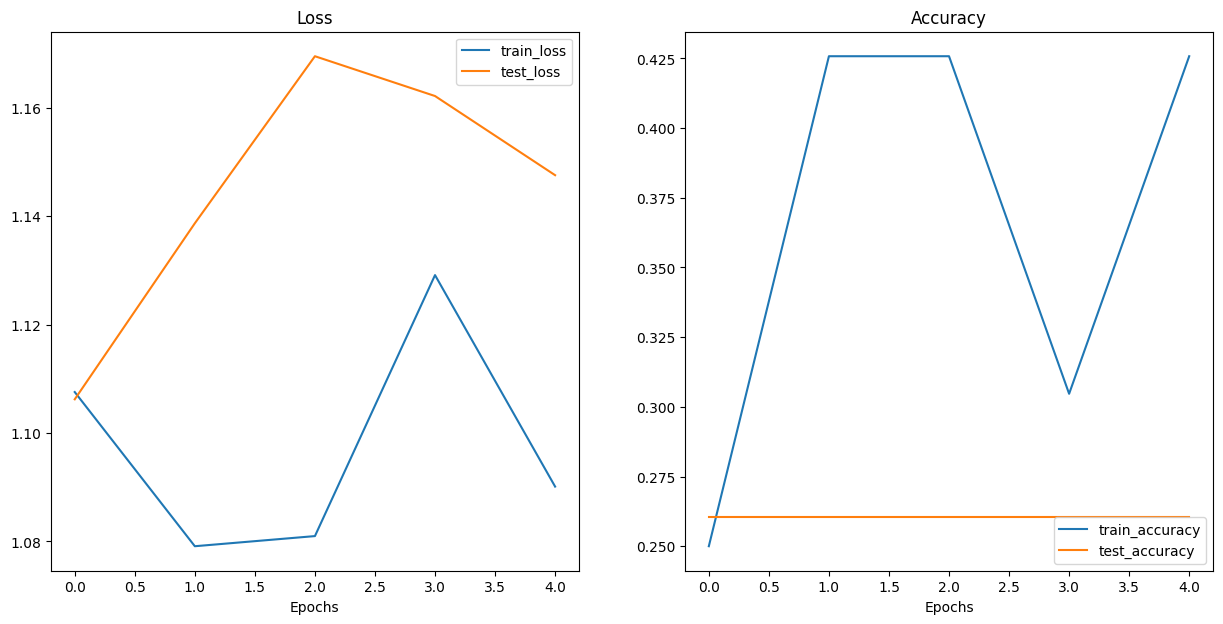

In [123]:
plot_loss_curves(model_1_results)

Wow...

These don't look very good either...

Is our model **underfitting** or **overfitting**?

Or both?

Ideally we'd like it have higher accuracy and lower loss right?

What are some methods you could try to use to achieve these?

## 10. Compare model results



Even though our models our performing quite poorly, we can still write code to compare them.

Let's first turn our model results into pandas DataFrames.

In [124]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.107836,0.257812,1.136208,0.260417
1,1.084645,0.425781,1.162169,0.197917
2,1.115263,0.292969,1.169472,0.197917
3,1.099033,0.289062,1.134185,0.197917
4,1.098892,0.292969,1.143380,0.197917


And now we can write some plotting code using `matplotlib` to visualize the results of `model_0` and `model_1` together.

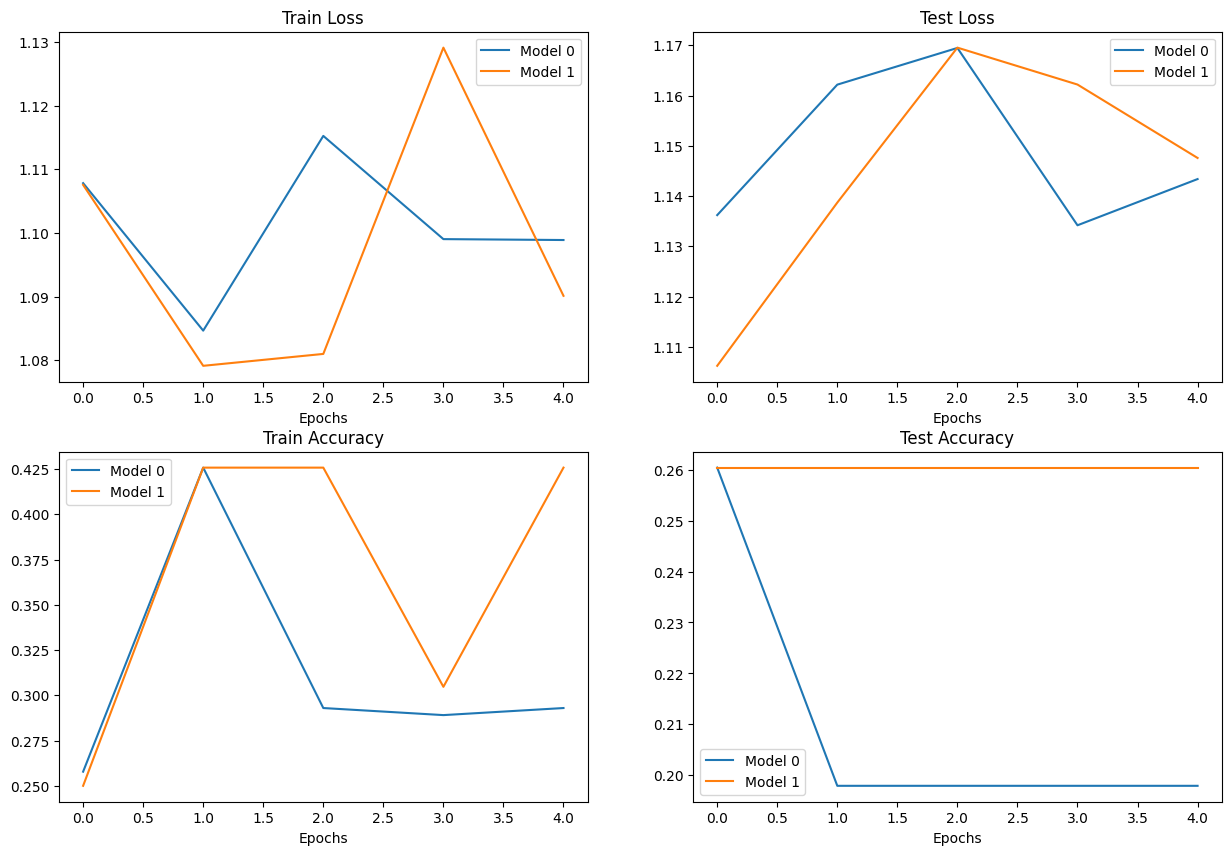

In [125]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

It looks like our models both performed equally poorly and were kind of sporadic (the metrics go up and down sharply).

If you built `model_2`, what would you do differently to try and improve performance?

## 11. Make a prediction on a custom image



If you've trained a model on a certain dataset, chances are you'd like to make a prediction on your own custom data.

In our case, since we've trained a model on pizza, steak and sushi images, how could we use our model to make a prediction on one of our own images?

To do so, we can load an image and then **preprocess it in a way that matches the type of data our model was trained on**.

In other words, we'll have to convert our own custom image to a tensor and make sure it's in the right datatype before passing it to our model.

Let's start by downloading a custom image.

Since our model predicts whether an image contains pizza, steak or sushi, let's download a photo of [my Dad giving two thumbs up to a big pizza from the Learn PyTorch for Deep Learning GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg).

We download the image using Python's `requests` module.

> **Note:** If you're using Google Colab, you can also upload an image to the current session by going to the left hand side menu -> Files -> Upload to session storage. Beware though, this image will delete when your Google Colab session ends.


In [126]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

data/04-pizza-dad.jpeg already exists, skipping download.


### 11.1 Loading in a custom image with PyTorch



Excellent!

Looks like we've got a custom image downloaded and ready to go at `data/04-pizza-dad.jpeg`.

Time to load it in.

PyTorch's `torchvision` has several input and output ("IO" or "io" for short) methods for reading and writing images and video in [`torchvision.io`](https://pytorch.org/vision/stable/io.html).

Since we want to load in an image, we'll use [`torchvision.io.read_image()`](https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html#torchvision.io.read_image).

This method will read a JPEG or PNG image and turn it into a 3 dimensional RGB or grayscale `torch.Tensor` with values of datatype `uint8` in range `[0, 255]`.

Let's try it out.

In [127]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 4032, 3024])

Custom image dty

#### Explanation of `torchvision.io` and Image Format Compatibility



- **`torchvision.io`** is a module in the `torchvision` library that provides functions for reading and writing images, videos, and other media formats in PyTorch. It is particularly useful for handling input/output (I/O) operations for computer vision tasks, such as loading images into tensors or saving tensors as image files.
- In the provided code, **`torchvision.io.read_image()`** is used to read an image file (JPEG or PNG) from the specified path (`custom_image_path`) and convert it into a **3D tensor** with shape `[C, H, W]` (channels, height, width). The tensor values are of type **`torch.uint8`** (unsigned 8-bit integers), with pixel values ranging from `[0, 255]`.
- The image has been successfully loaded into a tensor format, but we need to check if this format is compatible with our model. Currently, the `custom_image` tensor has:
  - **Datatype**: `torch.uint8` (values range from `[0, 255]`).
  - **Shape**: `[C, H, W]` (channels, height, width).
- However, our model expects:
  - **Datatype**: `torch.float32` (values normalized between `[0, 1]`).
  - **Shape**: `[C, H, W]` (same as the input, but with normalized values).
- **Action Required**:
  - Before using the image with our model, we must:
    1. Convert the tensor to `torch.float32`.
    2. Normalize the pixel values by dividing by `255` to scale them to `[0, 1]`.
  - If we skip this step, the model will throw an error because it expects data in a specific format.

#### Error Attempts

In [128]:
# # Try to make a prediction on image in uint8 format (this will error)
# model_1.eval()
# with torch.inference_mode():
#     model_1(custom_image_uint8.to(device))

If we try to make a prediction on an image in a different datatype to what our model was trained on, we get an error like the following:

> `RuntimeError: Input type (torch.cuda.ByteTensor) and weight type (torch.cuda.FloatTensor) should be the same`

Let's fix this by converting our custom image to the same datatype as what our model was trained on (`torch.float32`).

In [129]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..


Dividing by 255 scales pixel values from the range `[0, 255]` to `[0, 1]`. This normalization is necessary because many machine learning models, including those in PyTorch, expect input data to be in this range. Here's a more detailed breakdown:

1. **Pixel Values in 8-bit Images**:
   - In an 8-bit image, each pixel's intensity is represented by an integer between 0 (black) and 255 (white). This is the standard range for pixel values in most image formats.

2. **Normalization**:
   - Dividing by 255 converts these integer values into floating-point numbers between 0 and 1. This is called **normalization**.
   - Normalization ensures that the data is in a consistent range, which is important for the stability and performance of machine learning models.

3. **Model Compatibility**:
   - Many models are trained on normalized data (values between 0 and 1). If you feed the model data outside this range (e.g., values greater than 255 or negative values), it may not perform well or could even fail.
   - For example, if a pixel value is 300 (greater than 255), dividing by 255 would give a value greater than 1, which is outside the expected range. This could lead to incorrect predictions or numerical instability in the model.
   - Similarly, if the pixel values are smaller (e.g., 0 to 100), dividing by 255 would result in values between 0 and ~0.39, which is still within the expected range but may not fully utilize the model's capacity to distinguish between different intensities.

4. **Why 255?**:
   - The number 255 comes from the fact that 8-bit images use 8 bits to represent each pixel, and \(2^8 = 256\) possible values (0 to 255). Dividing by 255 scales these values to the range [0, 1].

5. **What if the Image is Not 8-bit?**:
   - If the image uses a different bit depth (e.g., 16-bit), the pixel values could range from 0 to 65535. In this case, you would divide by 65535 to normalize the values to [0, 1].


### 11.2 Predicting on custom images with a trained PyTorch model



Beautiful, it looks like our image data is now in the same format our model was trained on.

Except for one thing...

It's `shape`.

Our model was trained on images with shape `[3, 64, 64]`, whereas our custom image is currently `[3, 4032, 3024]`.

How could we make sure our custom image is the same shape as the images our model was trained on?

Are there any `torchvision.transforms` that could help?

Before we answer that question, let's plot the image with `matplotlib` to make sure it looks okay, remember we'll have to permute the dimensions from `CHW` to `HWC` to suit `matplotlib`'s requirements.

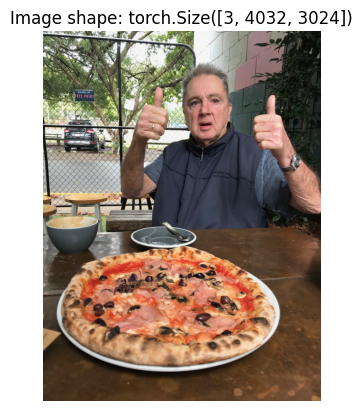

In [130]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

Two thumbs up!

Now how could we get our image to be the same size as the images our model was trained on?

One way to do so is with `torchvision.transforms.Resize()`.

Let's compose a transform pipeline to do so.

In [131]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


Woohoo!

Let's finally make a prediction on our own custom image.

#### Explanation of `transforms.Compose` and `transforms.Resize`



- **`transforms.Compose`**:
  - **Purpose**: `transforms.Compose` is a utility provided by the `torchvision.transforms` module that allows you to chain multiple image transformations together into a single pipeline. This is useful when you need to apply a sequence of transformations to your data in a specific order.
  - **How It Works**: You pass a list of transformations to `transforms.Compose`, and it applies them sequentially to the input image. For example, if you want to resize an image, flip it horizontally, and then convert it to a tensor, you can use `transforms.Compose` to combine these steps into one operation.
  - **Example**:
    ```python
    transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Resize the image to 64x64 pixels
        transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
        transforms.ToTensor()  # Convert the image to a tensor
    ])
    ```
    In this example, the image will first be resized, then flipped (if the random condition is met), and finally converted to a tensor.

- **`transforms.Resize`**:
  - **Purpose**: `transforms.Resize` is a transformation that resizes an image to the specified dimensions. It is commonly used to standardize the size of images in a dataset, which is necessary for training neural networks that expect inputs of a fixed size.
  - **Why It Needs to Be Inside `Compose`**: The `transforms.Resize` operation is just one of many possible transformations you might want to apply to an image. By placing it inside `transforms.Compose`, you can combine it with other transformations (e.g., flipping, cropping, converting to a tensor) into a single pipeline. This ensures that all transformations are applied in the correct order and simplifies the code.
  - **Example**:
    ```python
    transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Resize the image to 64x64 pixels
        transforms.ToTensor()  # Convert the image to a tensor
    ])
    ```
    Here, the image is first resized to 64x64 pixels and then converted to a tensor.

---

##### Why `Resize` Has to Go Inside `Compose`:
- **Sequential Application**: When you use `transforms.Compose`, the transformations are applied in the order they are listed. If you want to resize an image before performing other operations (e.g., converting it to a tensor), you need to include `transforms.Resize` inside `transforms.Compose`.
- **Code Organization**: Using `transforms.Compose` helps organize your code by grouping all transformations into a single object. This makes it easier to apply the same set of transformations consistently across your dataset.
- **Flexibility**: You can easily modify the transformation pipeline by adding or removing transformations within `transforms.Compose` without changing the rest of your code.

In summary, `transforms.Compose` is a powerful tool for chaining multiple image transformations, and `transforms.Resize` is one of the transformations that can be included in this pipeline to ensure images are resized before further processing.

#### Error

In [132]:
# This will error!

# model_1.eval()
# with torch.inference_mode():
#     custom_image_pred = model_1(custom_image_transformed)

Oh my goodness...

Despite our preparations our custom image and model are on different devices.

And we get the error:

> `RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper___slow_conv2d_forward)`

Let's fix that by putting our `custom_image_transformed` on the target device.

In [133]:
# model_1.eval()
# with torch.inference_mode():
#     custom_image_pred = model_1(custom_image_transformed.to(device))

What now?

It looks like we're getting a shape error.

Why might this be?

We converted our custom image to be the same size as the images our model was trained on...

Oh wait...

There's one dimension we forgot about.

The batch size.

Our model expects image tensors with a batch size dimension at the start (`NCHW` where `N` is the batch size).

Except our custom image is currently only `CHW`.

We can add a batch size dimension using `torch.unsqueeze(dim=0)` to add an extra dimension our image and *finally* make a prediction.

Essentially we'll be telling our model to predict on a single image (an image with a `batch_size` of 1).

In [134]:
model_1.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model_1(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


Yes!!!

It looks like it worked!

> **Note:** What we've just gone through are three of the classical and most common deep learning and PyTorch issues:
> 1. **Wrong datatypes** - our model expects `torch.float32` where our original custom image was `uint8`.
> 2. **Wrong device** - our model was on the target `device` (in our case, the GPU) whereas our target data hadn't been moved to the target `device` yet.
> 3. **Wrong shapes** - our model expected an input image of shape `[N, C, H, W]` or `[batch_size, color_channels, height, width]` whereas our custom image tensor was of shape `[color_channels, height, width]`.
>
> Keep in mind, these errors aren't just for predicting on custom images.
>
> They will be present with almost every kind of data type (text, audio, structured data) and problem you work with.

Now let's take a look at our model's predictions.

In [135]:
custom_image_pred

tensor([[ 0.1181,  0.0340, -0.1460]], device='cuda:0')

Alright, these are still in *logit form* (the raw outputs of a model are called logits).

Let's convert them from logits -> prediction probabilities -> prediction labels.

In [136]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.1181,  0.0340, -0.1460]], device='cuda:0')
Prediction probabilities: tensor([[0.3721, 0.3421, 0.2858]], device='cuda:0')
Prediction label: tensor([0], device='cuda:0')


Alright!

Looking good.

But of course our prediction label is still in index/tensor form.

We can convert it to a string class name prediction by indexing on the `class_names` list.

In [137]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'pizza'

Wow.

It looks like the model gets the prediction right, even though it was performing poorly based on our evaluation metrics.

> **Note:** The model in its current form will predict "pizza", "steak" or "sushi" no matter what image it's given. If you wanted your model to predict on a different class, you'd have to train it to do so.

But if we check the `custom_image_pred_probs`, we'll notice that the model gives almost equal weight (the values are similar) to every class.

In [138]:
# The values of the prediction probabilities are quite similar
custom_image_pred_probs

tensor([[0.3721, 0.3421, 0.2858]], device='cuda:0')

Having prediction probabilities this similar could mean a couple of things:
1. The model is trying to predict all three classes at the same time (there may be an image containing pizza, steak and sushi).
2. The model doesn't really know what it wants to predict and is in turn just assigning similar values to each of the classes.

Our case is number 2, since our model is poorly trained, it is basically *guessing* the prediction.

### 11.3 Putting custom image prediction together: building a function



Doing all of the above steps every time you'd like to make a prediction on a custom image would quickly become tedious.

So let's put them all together in a function we can easily use over and over again.

Specifically, let's make a function that:
1. Takes in a target image path and converts to the right datatype for our model (`torch.float32`).
2. Makes sure the target image pixel values are in the range `[0, 1]`.
3. Transforms the target image if necessary.
4. Makes sure the model is on the target device.
5. Makes a prediction on the target image with a trained model (ensuring the image is the right size and on the same device as the model).
6. Converts the model's output logits to prediction probabilities.
7. Converts the prediction probabilities to prediction labels.
8. Plots the target image alongside the model prediction and prediction probability.

A fair few steps but we've got this!